# Kaggle challenge

In [1]:
# Loading and general processing of the data

import os
import numpy as np
import nibabel as nib
import pandas as pd
import cv2

# Visualization specific
import matplotlib.pyplot as plt


# Diverse
from tqdm import tqdm


## Storing data, completing segmentation, submission function

In [2]:
import os
import nibabel as nib

def load_data(path='Dataset/Train/', testing_base_path='Dataset/Test/'):
    data = {"ED":{"images":[], "seg":[], 'images_metadata':[], 'seg_metadata':[]}, "ES":{"images":[], "seg":[], 'images_metadata':[], 'seg_metadata':[]}}
    training_folders = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
        
    for folder in training_folders:
       
        ed_seg_img = nib.load(os.path.join(path, folder, f'{folder}_ED_seg.nii'))
        ed_img = nib.load(os.path.join(path, folder, f'{folder}_ED.nii'))
        es_seg_img = nib.load(os.path.join(path, folder, f'{folder}_ES_seg.nii'))
        es_img = nib.load(os.path.join(path, folder, f'{folder}_ES.nii'))
        
        data['ED']['seg'].append(ed_seg_img.get_fdata())
        data['ED']['images'].append(ed_img.get_fdata())
        data['ES']['seg'].append(es_seg_img.get_fdata())
        data['ES']['images'].append(es_img.get_fdata())
        
        data['ED']['seg_metadata'].append(ed_seg_img.header)
        data['ED']['images_metadata'].append(ed_img.header)
        data['ES']['seg_metadata'].append(es_seg_img.header)
        data['ES']['images_metadata'].append(es_img.header)

     
        
    return data

### Definition of the data_set

In [3]:
trainData = load_data(path='Dataset/Train/')
nTrain = len(trainData['ED']['images'])

testData = load_data(path='Dataset/Test/')
nTest = len(testData['ED']['images'])

print(f'Number of patients in train/validation: {nTrain}')
print(f'Number of patients in test: {nTest}')


Number of patients in train/validation: 100
Number of patients in test: 50


### Visualize data

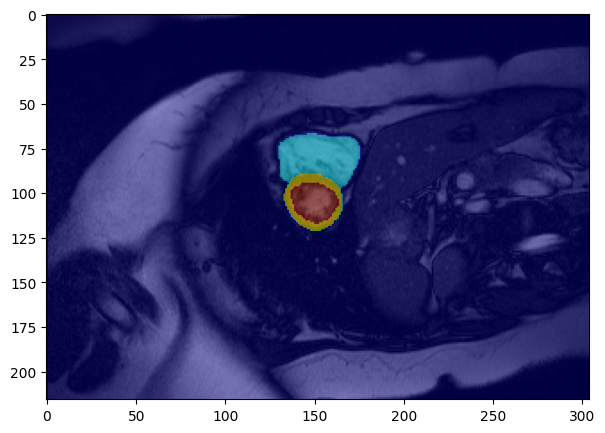

In [4]:
plt.figure(figsize=(7, 7))
plt.imshow(trainData['ED']['images'][99][:, :, 5], cmap='gray')
plt.imshow(trainData['ED']['seg'][99][:, :, 5], cmap='jet', alpha=0.5)

### Dimensions of the data

In [5]:
shapes = np.array([trainData['ED']['images'][i].shape for i in range(nTrain)])

min_shape = np.min(shapes, axis=0)
max_shape = np.max(shapes, axis=0)

print('minimum shape of data:', min_shape)
print('maximum shape of data:', max_shape)


minimum shape of data: [154 154   6]
maximum shape of data: [428 512  18]


### Values in greyscale images

In [6]:
max_ED = max([np.max(trainData['ED']['images'][i]) for i in range(nTrain)])
min_ED = min([np.min(trainData['ED']['images'][i]) for i in range(nTrain)])

print('maximum and minimum values in images', max_ED, min_ED)

max_ES = max([np.max(trainData['ES']['images'][i]) for i in range(nTrain)])
min_ES = min([np.min(trainData['ES']['images'][i]) for i in range(nTrain)])

print('maximum and minimum values in images',max_ES, min_ES)

maximum and minimum values in images 4025.0 0.0
maximum and minimum values in images 4031.0 0.0


#### Segmentation

In [7]:
#printing labels in train and test data
trainSegmentationValues = np.unique(np.concatenate([np.unique(trainData['ED']['seg'][i]) for i in range(nTrain)]))
print(trainSegmentationValues)

testSegmentationValues = np.unique(np.concatenate([np.unique(testData['ES']['seg'][i]) for i in range(nTest)]))
print(testSegmentationValues)

[0. 1. 2. 3.]
[0. 1. 2.]


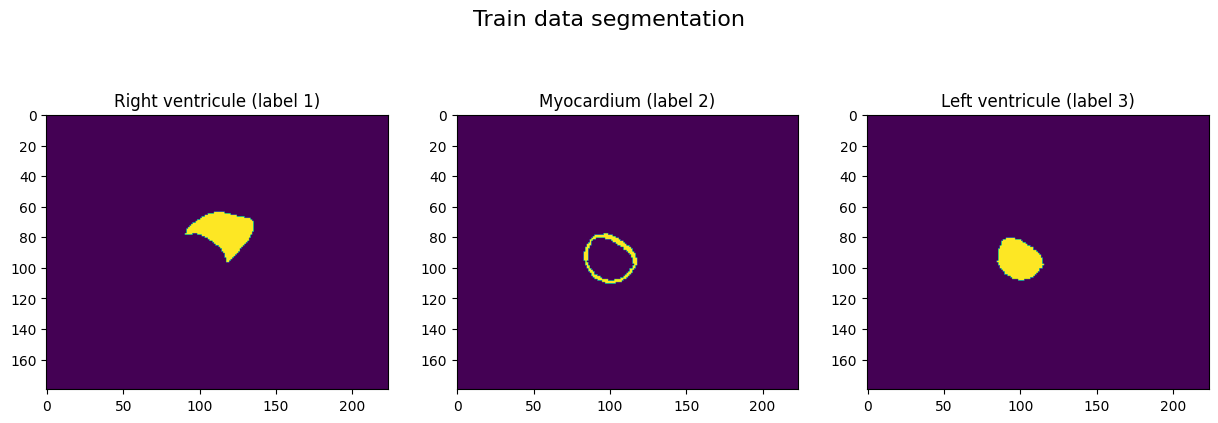

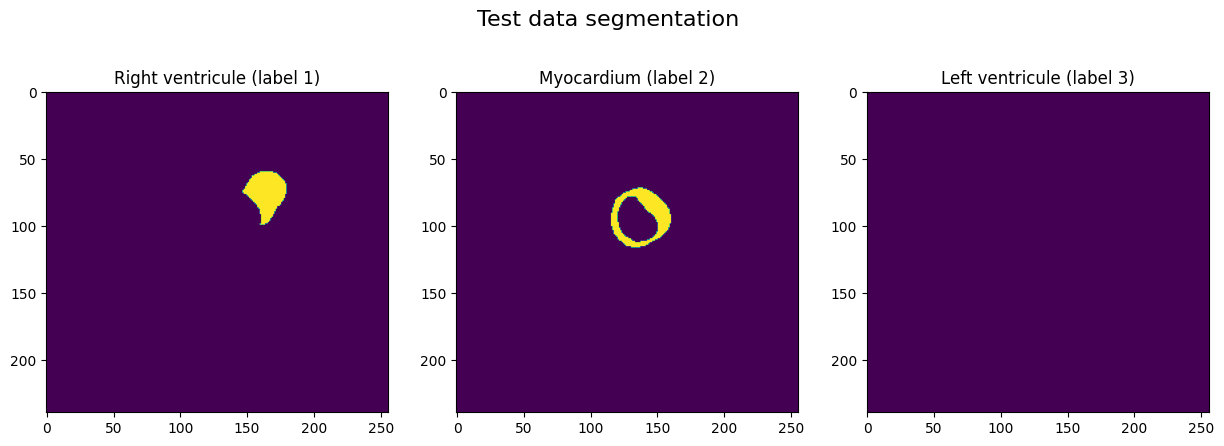

In [8]:
#pringing segmentation values in train and test data
patient = 90
frame = 5

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(trainData['ED']['seg'][patient][:, :, frame] == 1, cmap='viridis')
ax[0].set_title('Right ventricule (label 1)')
ax[1].imshow(trainData['ED']['seg'][patient][:, :, frame] == 2, cmap='viridis')
ax[1].set_title('Myocardium (label 2)')
ax[2].imshow(trainData['ED']['seg'][patient][:, :, frame] == 3, cmap='viridis')
ax[2].set_title('Left ventricule (label 3)')
fig.suptitle('Train data segmentation', fontsize=16)
plt.show()

patient = 10
frame = 5
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(testData['ED']['seg'][patient][:, :, frame] == 1, cmap='viridis')
ax[0].set_title('Right ventricule (label 1)')
ax[1].imshow(testData['ED']['seg'][patient][:, :, frame] == 2, cmap='viridis')
ax[1].set_title('Myocardium (label 2)')
ax[2].imshow(testData['ED']['seg'][patient][:, :, frame] == 3, cmap='viridis')
ax[2].set_title('Left ventricule (label 3)')
fig.suptitle('Test data segmentation', fontsize=16)
plt.show()

We observe that the left ventricule segmentation is missing in the test data set

### Global variable def for labelling

In [9]:
RV = 1
MYO = 2
LV = 3

### Metadata extraction

In [10]:
def addMetaData(data, path='Dataset/metaDataTrain.csv', train=True):
    """Ddd height, weight to the data and category for training data

    Args:
        data (dict): data dictionary
        path (str, optional): csv file path of the metadata file. Defaults to 'Dataset/metaDataTrain.csv'.
        train (bool, optional): tells if the data is training data. Defaults to True.
        
    Returns:
        None
    """
    
    metaData = pd.read_csv(path)
    
    if train:
        data["category"] = []
    data["height"] = []
    data["weight"] = []    
    
    for index in range(len(metaData['Id'].values)):
        
        if train:
            data["category"].append(metaData['Category'][index])
        data["height"].append(metaData['Height'][index])
        data["weight"].append(metaData['Weight'][index])
    
    return None
    

In [11]:
#adding metadata to the data
addMetaData(trainData)
addMetaData(testData, path='Dataset/metaDataTest.csv', train=False)

In [12]:
#checking the metadata
trainData["height"][0], trainData["weight"][0], trainData["category"][0]

(184.0, 95.0, 2)

### LV segmentation

In [13]:
def addLVseg(seg):
    """Add the segmentation of the LV to a segmentation containing only myocardium and RV segmentation. 

    Args:
        seg (numpy arry): segmentation missing the LV

    Returns:
        numpy array: the new segmentation with the LV
    """
    labels = np.unique(seg)
    
    if MYO in labels:
        binary_mask = np.copy(seg)
        # segWithoutLV[segWithoutLV != MYO] = 0
        binary_mask = (binary_mask != 0).astype(np.uint8)*255
        print(np.unique(binary_mask))
        # binary_mask = binary_mask.astype(np.uint8)
        
        # kernel = np.array([[0,1,0],
        #            [1,1,1],
        #            [0,1,0]], dtype=np.uint8)
        kernel = np.array([[0,0,0],
                   [0,1,0],
                   [0,0,0]], dtype=np.uint8)

        # binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        print(contours)
        contour = contours[0]
        
        # min1, min2 = np.min(contour, axis=0)[0]
        # max1, max2 = np.max(contour, axis=0)[0]
        # print(min1, min2, max1, max2)    
        
        # print(min(contours[0][:,0,0]), max(contours[0][:,0,0]), min(contours[0][:,0,1]), max(contours[0][:,0,1]))
        print("binary_mask.shape", binary_mask.shape)
        filled_mask = np.zeros_like(binary_mask, dtype=np.uint8)
        print(filled_mask.shape)
        plt.imshow(filled_mask)
        plt.show()
        # print(contours)
        cv2.drawContours(filled_mask, contours, -1, (255), thickness=cv2.FILLED)
        
        
        
        inside = np.where((filled_mask == 255) & (binary_mask==0), 255, 0)
  
        inside = inside.astype(np.uint8)
        # inside = cv2.dilate(inside, kernel, iterations=1)

        # inside[inside == 255] = LV

        # final_seg = inside + seg
        
        # Keep only the largest connected component
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inside, connectivity=8)
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Skip the background label 0
        largest_component = np.where(labels == largest_label, 255, 0).astype(np.uint8)
        
        largest_component[largest_component == 255] = LV

        final_seg = largest_component + seg
        
        # binary_final_seg = final_seg[final_seg != 0]
        
        # for i in range(min2, max2+1):
        #     for j in range(min1, max1+1):
                
                
        #         if final_seg[i,j] == 0 and (np.sum(final_seg[i-1:i+2, j-1:j+2]==0) == 1)and (LV in final_seg[i-1:i+2, j-1:j+2]) and (MYO in final_seg[i-1:i+2, j-1:j+2]) :
               
        #             final_seg[i,j] = LV
        
    
        return final_seg

    
    else:
        return seg

def completePatientSeg(data, patient):
    
    """
    Complete the heart segmentation of a patient by segmenting the left ventricle in each frame of the sequence.
    
    Args:
        data (dict): dictionary containing the data
        patient (int): patient index
        
    Returns:
        None
    """
    
    ED_seg = data["ED_seg"][patient]
    ES_seg = data["ES_seg"][patient]
    
    for frame in range(ED_seg.shape[2]):
        ED_seg[:, :, frame] = addLVseg(ED_seg[:, :, frame])
        ES_seg[:, :, frame] = addLVseg(ES_seg[:, :, frame])
    

def dataLVsegmentation(data):
    """Add the left ventricle segmentation to the data

    Args:
        data (dict): data list

    Returns:
        None
    """
    
    for im in data:
        for frame in range(im.shape[2]):
            im[:, :, frame] = addLVseg(im[:, :, frame])
        
    
    return None


In [14]:
def addLVseg(seg):
    """Add the segmentation of the LV to a segmentation containing only myocardium and RV segmentation. 

    Args:
        seg (numpy arry): segmentation missing the LV

    Returns:
        numpy array: the new segmentation with the LV
    """
    labels = np.unique(seg)
    
    if MYO in labels:
        binary_mask = np.copy(seg)

        ret, binary_mask = cv2.threshold(seg, 1, 255, cv2.THRESH_BINARY)

        binary_mask = binary_mask.astype(np.uint8)


       
        
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # print(contours)
        filled_mask = np.zeros_like(binary_mask)

        cv2.drawContours(filled_mask, contours, -1, (255), thickness=cv2.FILLED)
        
        
        
        inside = np.where((filled_mask == 255) & (binary_mask==0), 255, 0)
  
        inside = inside.astype(np.uint8)
        
            
        
        # inside = cv2.dilate(inside, kernel, iterations=1)
        if np.sum(inside) == 0:
            kernel = np.array([[0,1,0],
                   [1,1,1],
                   [0,1,0]], dtype=np.uint8)
            binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)
            
            binary_mask = binary_mask.astype(np.uint8)


       
        
            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            # print(contours)
            contour = contours[0]
            min1, min2 = np.min(contour, axis=0)[0]
            max1, max2 = np.max(contour, axis=0)[0]
            
            filled_mask = np.zeros_like(binary_mask)

            cv2.drawContours(filled_mask, contours, -1, (255), thickness=cv2.FILLED)
            
            
            
            inside = np.where((filled_mask == 255) & (binary_mask==0), 255, 0)
    
            inside = inside.astype(np.uint8)
            
            inside = cv2.dilate(inside, kernel, iterations=1)

            inside[inside == 255] = LV

            final_seg = inside + seg
            
            for i in range(min2, max2+1):
                for j in range(min1, max1+1):
                    
                    
                    if final_seg[i,j] == 0 and (np.sum(final_seg[i-1:i+2, j-1:j+2]==0) == 1)and (LV in final_seg[i-1:i+2, j-1:j+2]) and (MYO in final_seg[i-1:i+2, j-1:j+2]) :
                
                        final_seg[i,j] = LV
            
            return final_seg
        try:
            num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inside, connectivity=8)
            largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Skip the background label 0
            largest_component = np.where(labels == largest_label, 255, 0).astype(np.uint8)
            
            largest_component[largest_component == 255] = LV

            final_seg = largest_component + seg
            return final_seg
        except:
            
            final_seg = seg + inside
            return final_seg

        # inside[inside == 255] = LV

        # final_seg = inside + seg
        # binary_final_seg = final_seg[final_seg != 0]
        
        # for i in range(min2, max2+1):
        #     for j in range(min1, max1+1):
                
                
        #         if final_seg[i,j] == 0 and (np.sum(final_seg[i-1:i+2, j-1:j+2]==0) == 1)and (LV in final_seg[i-1:i+2, j-1:j+2]) and (MYO in final_seg[i-1:i+2, j-1:j+2]) :
               
        #             final_seg[i,j] = LV
        
    
        # return final_seg

    
    else:
        return seg

def completePatientSeg(data, patient):
    
    """
    Complete the heart segmentation of a patient by segmenting the left ventricle in each frame of the sequence.
    
    Args:
        data (dict): dictionary containing the data
        patient (int): patient index
        
    Returns:
        None
    """
    
    ED_seg = data["ED_seg"][patient]
    ES_seg = data["ES_seg"][patient]
    
    for frame in range(ED_seg.shape[2]):
        ED_seg[:, :, frame] = addLVseg(ED_seg[:, :, frame])
        ES_seg[:, :, frame] = addLVseg(ES_seg[:, :, frame])
    

def dataLVsegmentation(data):
    """Add the left ventricle segmentation to the data

    Args:
        data (dict): data list

    Returns:
        None
    """
    
    for im in data:
        for frame in range(im.shape[2]):
            im[:, :, frame] = addLVseg(im[:, :, frame])
        
    
    return None


In [15]:
def addLVsegMainMethod(seg):
    """Add the segmentation of the LV to a segmentation containing only myocardium and RV segmentation.
    The contours of the segmentation including the RV and the myocardium are extracted. 
    We fill this contour and set to LV all the pixels chich used to be zero. 
    We then only keep the largest connected component. 
    If the contour is not closed, we use a morphological dilatation to close it.
    
    Args:
        seg (numpy arry): segmentation missing the LV

    Returns:
        numpy array: the new segmentation with the LV
    """
    labels = np.unique(seg)
    
    if MYO in labels:
        binary_mask = np.copy(seg)

        ret, binary_mask = cv2.threshold(seg, 1, 255, cv2.THRESH_BINARY)

        binary_mask = binary_mask.astype(np.uint8)

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # print(contours)
        filled_mask = np.zeros_like(binary_mask)

        cv2.drawContours(filled_mask, contours, -1, (255), thickness=cv2.FILLED)
        
        
        
        inside = np.where((filled_mask == 255) & (binary_mask==0), 255, 0)
  
        inside = inside.astype(np.uint8)
        
        inside[inside == 255] = LV

        final_seg = inside + seg
     
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inside, connectivity=8)
        try:
            largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Skip the background label 0
            largest_component = np.where(labels == largest_label, 255, 0).astype(np.uint8)
            
            largest_component[largest_component == 255] = LV

            final_seg = largest_component + seg
            return final_seg
        except:
            return final_seg

    else:
        return seg

def completePatientSeg(data, patient):
    
    """
    Complete the heart segmentation of a patient by segmenting the left ventricle in each frame of the sequence.
    
    Args:
        data (dict): dictionary containing the data
        patient (int): patient index
        
    Returns:
        None
    """
    
    ED_seg = data["ED"]["seg"][patient]
    ES_seg = data["ES"]["seg"][patient]
    
    for frame in range(ED_seg.shape[2]):
        ED_seg[:, :, frame] = addLVseg(ED_seg[:, :, frame])
        ES_seg[:, :, frame] = addLVseg(ES_seg[:, :, frame])
    

def dataLVsegmentationMainMethod(data):
    """Add the left ventricle segmentation to the data

    Args:
        data (dict): data list

    Returns:
        None
    """
    
    for im in data:
        for frame in range(im.shape[2]):
            im[:, :, frame] = addLVsegMainMethod(im[:, :, frame])
        
    
    return None


In [16]:
#deleting LV
def deleteLV(data):
    dataWithoutLV = [np.copy(im) for im in data]
    for im in dataWithoutLV:
        im[im == LV] = 0
    return dataWithoutLV


ED_seg = trainData["ED"]["seg"]
ED_segWithoutLV = deleteLV(ED_seg)

ES_seg = trainData["ES"]["seg"]
ES_segWithoutLV = deleteLV(ES_seg)

In [17]:
#segmenting LV
new_ED_seg = [np.copy(im) for im in ED_segWithoutLV]
new_ES_seg = [np.copy(im) for im in ES_segWithoutLV]
dataLVsegmentationMainMethod(new_ED_seg)
dataLVsegmentationMainMethod(new_ES_seg)

In [18]:
#Comparing our segmentation with the original segmentation
#checking if segmentations after deleting LV and then segmenting are equal to the original segmentations


def arrays_equal(list1, list2):
    same = True
    if len(list1) != len(list2):
        print("different lengths")
        return False
    
    for i, (arr1, arr2) in enumerate(zip(list1, list2)):
       
        if not np.array_equal(arr1, arr2):
            print(f"Not the same segmentation for patient {i}")
            same = False
    return same

print("Diastole")
print("Segmentations are the same", arrays_equal(ED_seg, new_ED_seg))
print()
print("Systole")
print("Segmentations are the same", arrays_equal(ES_seg, new_ES_seg))

Diastole
Not the same segmentation for patient 10
Not the same segmentation for patient 28
Segmentations are the same False

Systole
Not the same segmentation for patient 44
Not the same segmentation for patient 67
Not the same segmentation for patient 68
Not the same segmentation for patient 83
Not the same segmentation for patient 95
Segmentations are the same False


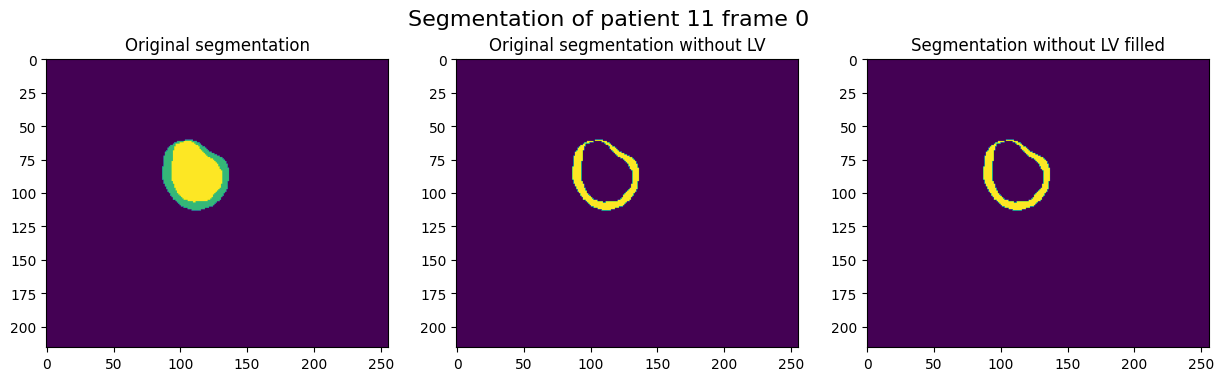

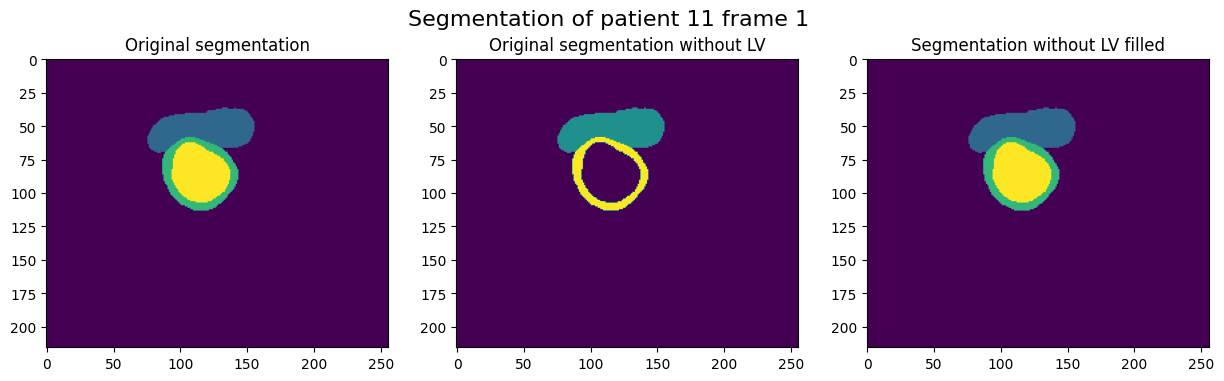

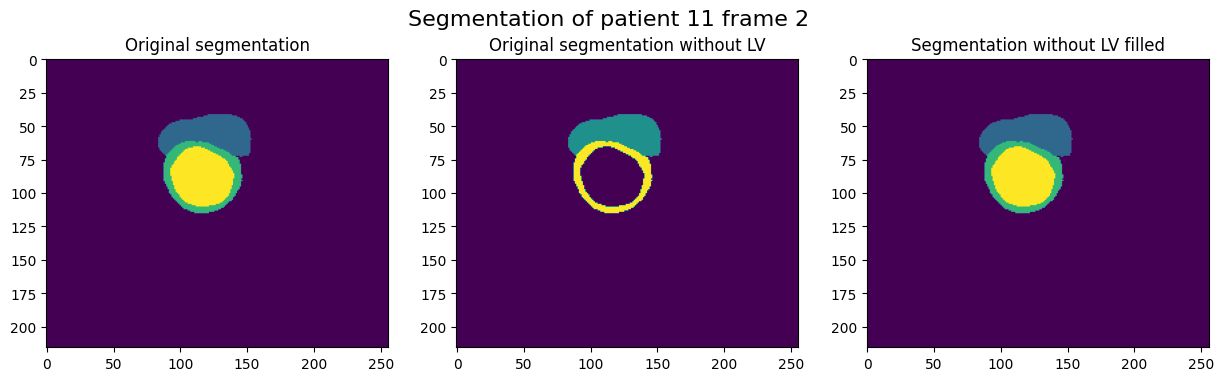

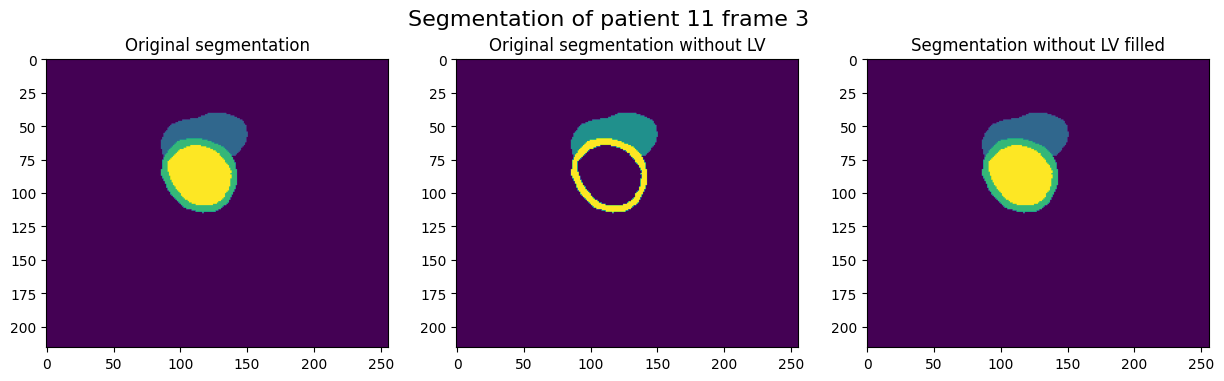

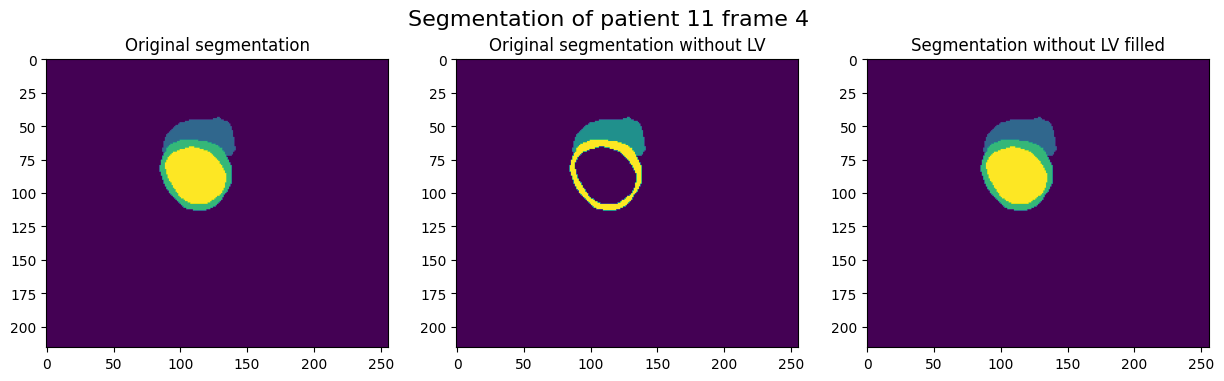

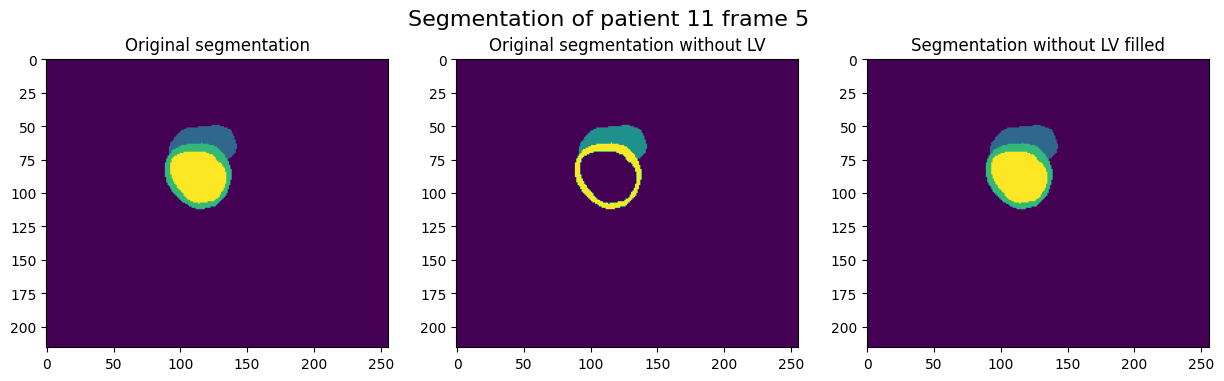

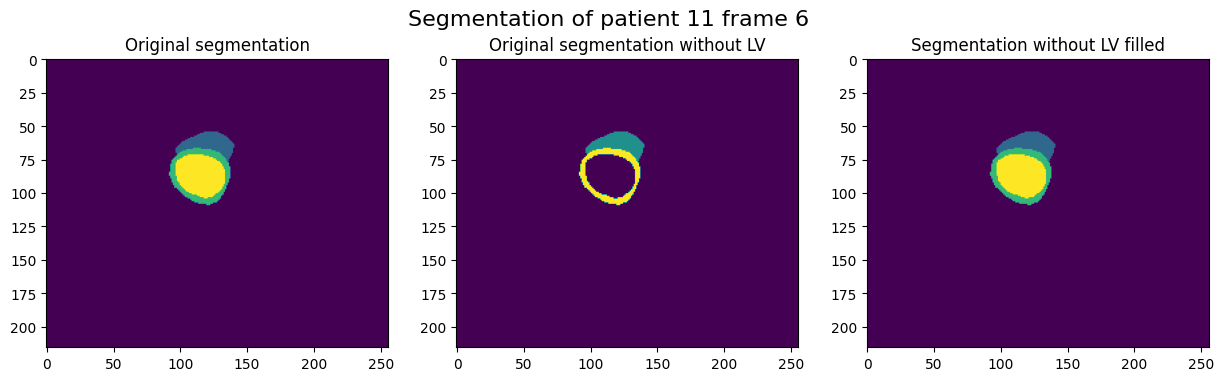

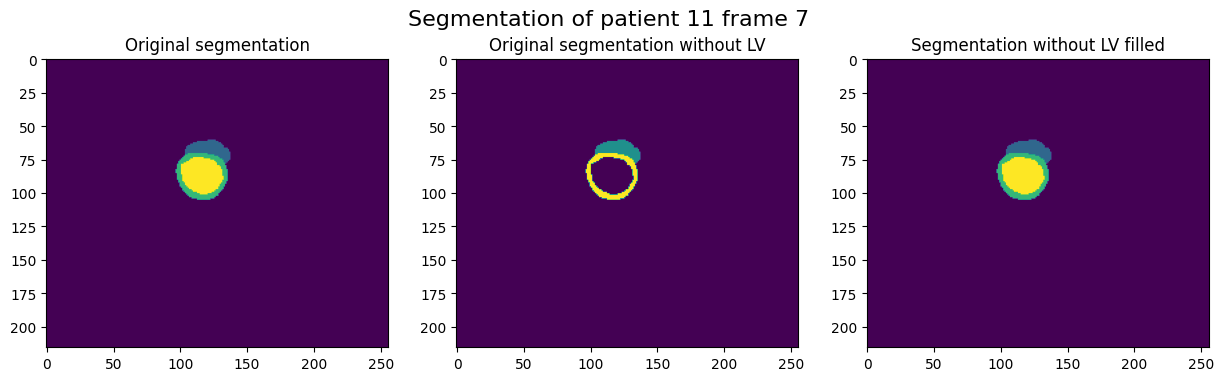

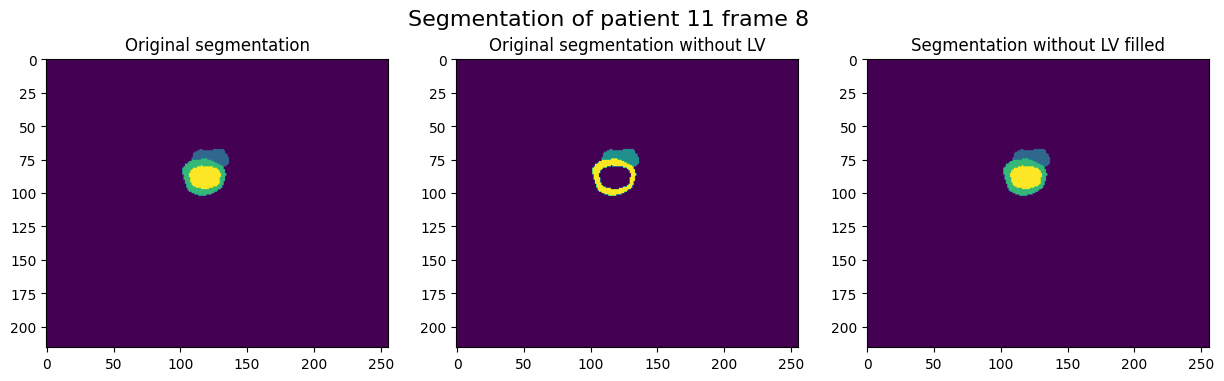

In [19]:
index = 10
for frame in range(ED_seg[index].shape[2]):

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    ax[0].imshow(ED_seg[index][:, :, frame], cmap='viridis')
    ax[0].set_title('Original segmentation')
    ax[2].imshow(new_ED_seg[index][:, :, frame], cmap='viridis')
    ax[2].set_title('Segmentation without LV filled')
    ax[1].imshow(ED_segWithoutLV[index][:, :, frame], cmap='viridis')
    ax[1].set_title('Original segmentation without LV')

    fig.suptitle(f'Segmentation of patient {index+1} frame {frame}', fontsize=16)
    plt.show()

In [20]:
def addLVseg(seg):
    """Add the segmentation of the LV to a segmentation containing only myocardium and RV segmentation.
    The contours of the segmentation including the RV and the myocardium are extracted. 
    We fill this contour and set to LV all the pixels chich used to be zero. 
    We then only keep the largest connected component. 
    If the contour is not closed, we use a morphological dilatation to close it.
    
    Args:
        seg (numpy arry): segmentation missing the LV

    Returns:
        numpy array: the new segmentation with the LV
    """
    labels = np.unique(seg)
    
    if MYO in labels:
        binary_mask = np.copy(seg)

        ret, binary_mask = cv2.threshold(seg, 1, 255, cv2.THRESH_BINARY)

        binary_mask = binary_mask.astype(np.uint8)

        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # print(contours)
        filled_mask = np.zeros_like(binary_mask)

        cv2.drawContours(filled_mask, contours, -1, (255), thickness=cv2.FILLED)
        
        
        
        inside = np.where((filled_mask == 255) & (binary_mask==0), 255, 0)
  
        inside = inside.astype(np.uint8)
        
        if np.sum(inside) == 0:
            kernel = np.array([[0,1,0],
                   [1,1,1],
                   [0,1,0]], dtype=np.uint8)
            binary_mask = cv2.dilate(binary_mask, kernel, iterations=1)
            
            binary_mask = binary_mask.astype(np.uint8)

            contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
 
            contour = contours[0]
            min1, min2 = np.min(contour, axis=0)[0]
            max1, max2 = np.max(contour, axis=0)[0]
            
            filled_mask = np.zeros_like(binary_mask)

            cv2.drawContours(filled_mask, contours, -1, (255), thickness=cv2.FILLED)
            
            
            
            inside = np.where((filled_mask == 255) & (binary_mask==0), 255, 0)
    
            inside = inside.astype(np.uint8)
            
            inside = cv2.dilate(inside, kernel, iterations=1)

            inside[inside == 255] = LV

            final_seg = inside + seg
            
            for i in range(min2, max2+1):
                for j in range(min1, max1+1):
                    
                    
                    if final_seg[i,j] == 0 and (np.sum(final_seg[i-1:i+2, j-1:j+2]==0) == 1)and (LV in final_seg[i-1:i+2, j-1:j+2]) and (MYO in final_seg[i-1:i+2, j-1:j+2]) :
                
                        final_seg[i,j] = LV
            
            return final_seg
     
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(inside, connectivity=8)
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])  # Skip the background label 0
        largest_component = np.where(labels == largest_label, 255, 0).astype(np.uint8)
        
        largest_component[largest_component == 255] = LV

        final_seg = largest_component + seg
        return final_seg

    else:
        return seg

def completePatientSeg(data, patient):
    
    """
    Complete the heart segmentation of a patient by segmenting the left ventricle in each frame of the sequence.
    
    Args:
        data (dict): dictionary containing the data
        patient (int): patient index
        
    Returns:
        None
    """
    
    ED_seg = data["ED"]["seg"][patient]
    ES_seg = data["ES"]["seg"][patient]
    
    for frame in range(ED_seg.shape[2]):
        ED_seg[:, :, frame] = addLVseg(ED_seg[:, :, frame])
        ES_seg[:, :, frame] = addLVseg(ES_seg[:, :, frame])
    

def dataLVsegmentation(data):
    """Add the left ventricle segmentation to the data

    Args:
        data (dict): data list

    Returns:
        None
    """
    
    for im in data:
        for frame in range(im.shape[2]):
            im[:, :, frame] = addLVseg(im[:, :, frame])
        
    
    return None


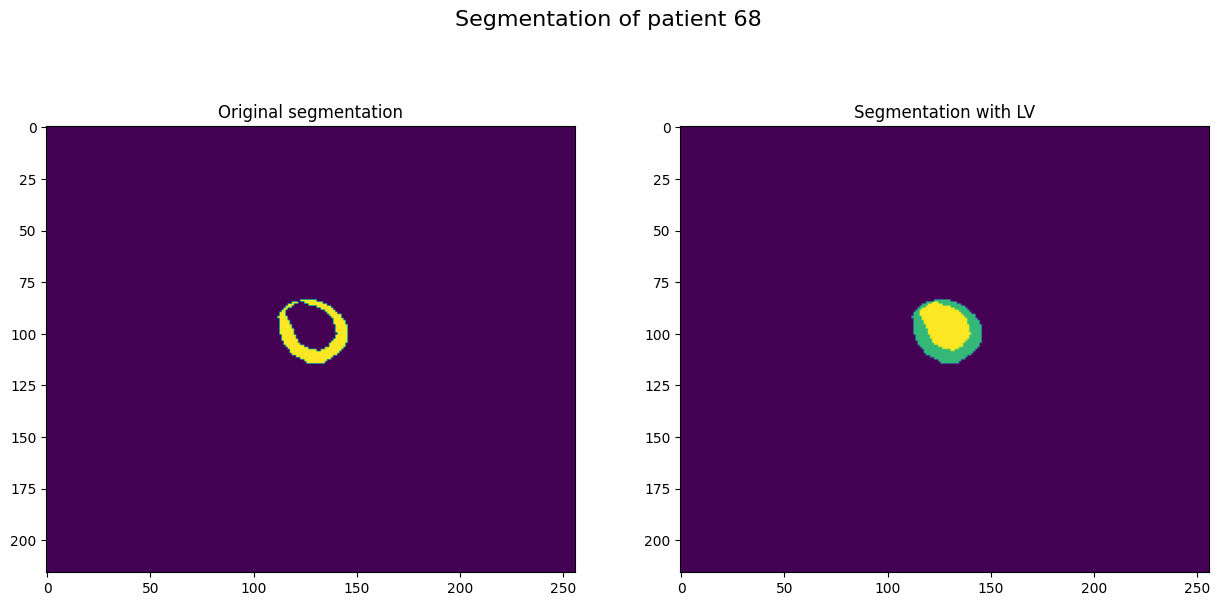

In [21]:
#ploting one segmentation in the train data after deleting the LV
def deleteLV(data):
    dataWithoutLV = [np.copy(im) for im in data]
    for im in dataWithoutLV:
        im[im == LV] = 0
    return dataWithoutLV
    
seg = trainData["ES"]["seg"]
segWithoutLV = deleteLV(seg)


patientId = 68
frame=0

seg = np.copy(segWithoutLV[patientId][:, :, frame])
segCompleted = addLVseg(seg)


fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(seg, cmap='viridis')
ax[0].set_title('Original segmentation')
ax[1].imshow(segCompleted[:,:], cmap='viridis')
ax[1].set_title('Segmentation with LV')
fig.suptitle(f'Segmentation of patient {patientId}', fontsize=16)
plt.show()

When needed, the function uses morphological dilatation to close the shape of the myocardium. It allows to complete the segmentation.

We are going to test our segmentation of the LV on the whole train data to check if we segment LV properly. To do so, I deleted the LV from the segmentation and tried to segment it afterwards using only the myocardium and the RV.

In [22]:
#deleting LV
def deleteLV(data):
    dataWithoutLV = [np.copy(im) for im in data]
    for im in dataWithoutLV:
        im[im == LV] = 0
    return dataWithoutLV


ED_seg = trainData["ED"]["seg"]
ED_segWithoutLV = deleteLV(ED_seg)

ES_seg = trainData["ES"]["seg"]
ES_segWithoutLV = deleteLV(ES_seg)

In [23]:
#segmenting LV
new_ED_seg = [np.copy(im) for im in ED_segWithoutLV]
new_ES_seg = [np.copy(im) for im in ES_segWithoutLV]
dataLVsegmentation(new_ED_seg)
dataLVsegmentation(new_ES_seg)

In [24]:
#Comparing our segmentation with the original segmentation
#checking if segmentations after deleting LV and then segmenting are equal to the original segmentations


def arrays_equal(list1, list2):
    same = True
    if len(list1) != len(list2):
        print("different lengths")
        return False
    
    for i, (arr1, arr2) in enumerate(zip(list1, list2)):
       
        if not np.array_equal(arr1, arr2):
            print(f"Not the same segmentation for patient {i}")
            same = False
    return same

print("Diastole")
print("Segmentations are the same", arrays_equal(ED_seg, new_ED_seg))
print()
print("Systole")
print("Segmentations are the same", arrays_equal(ES_seg, new_ES_seg))

Diastole
Not the same segmentation for patient 28
Segmentations are the same False

Systole
Segmentations are the same True


With our algorithm, segmentations of the LV are always identical to the original segmentation except for patient 28.

As shown below, the myocaridum is opened too widely to allow such segmentation as we did. We will then avoid frames missing the LV segmentation (for further processing of the data) as it only happens for 1 frame in the training data.

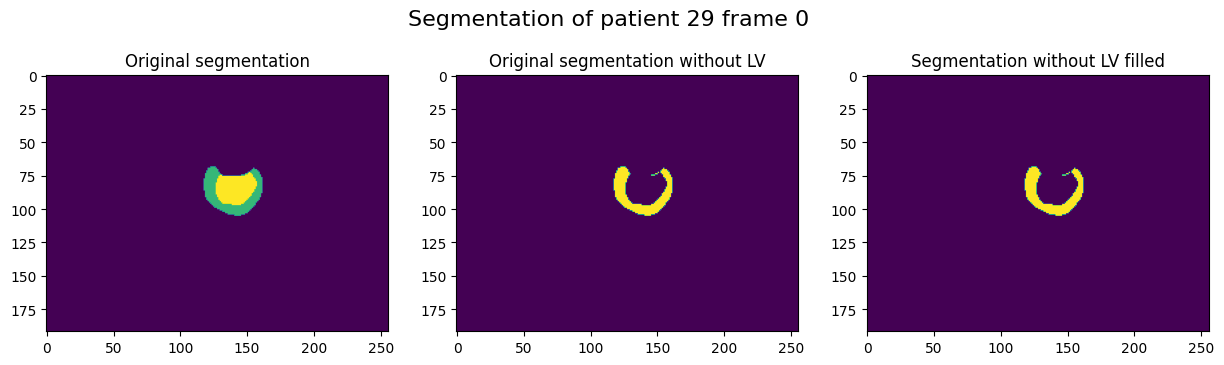

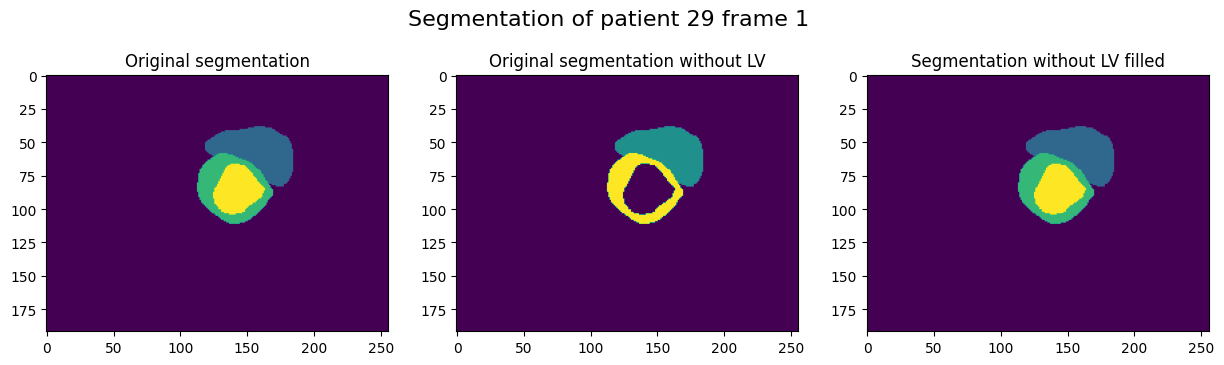

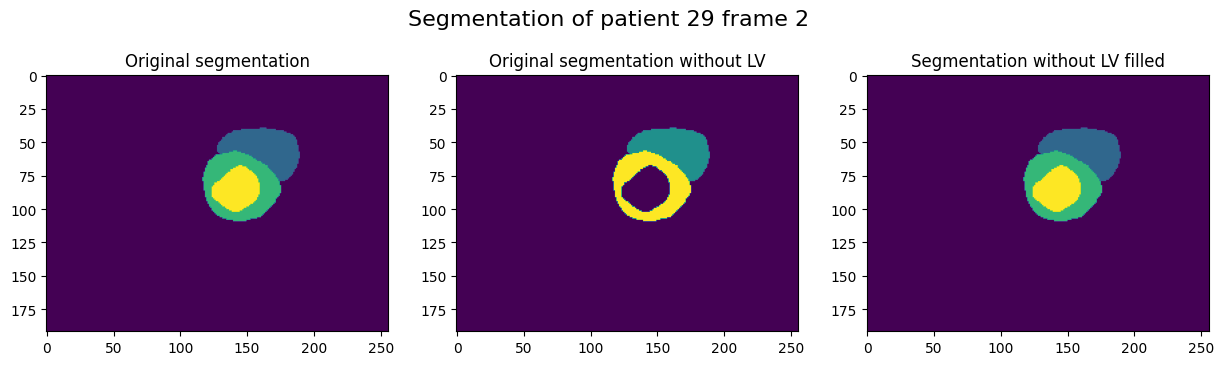

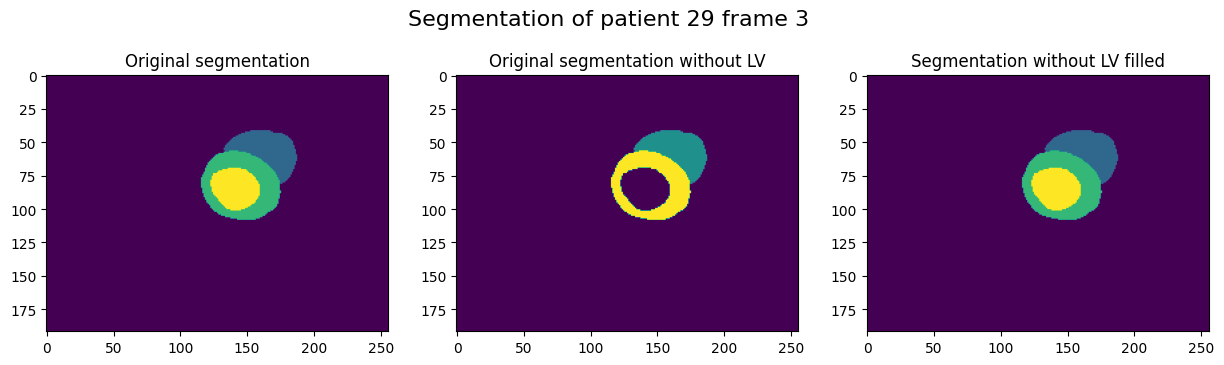

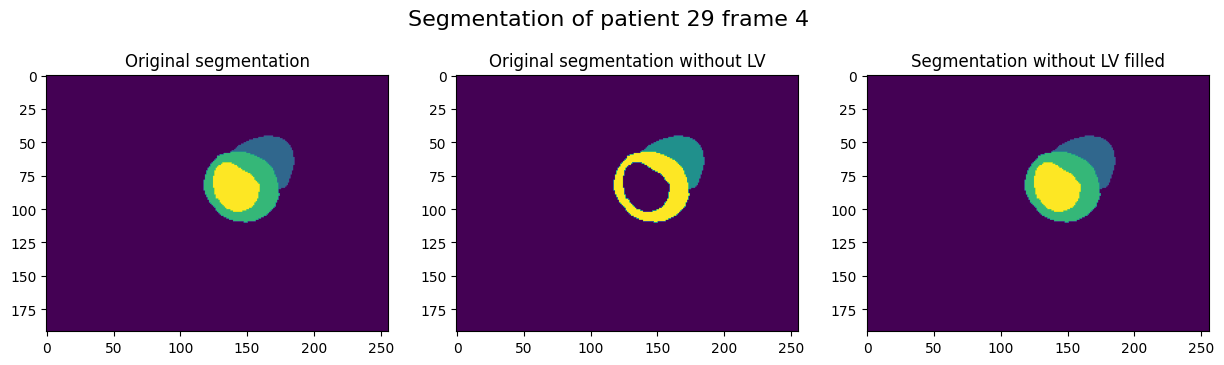

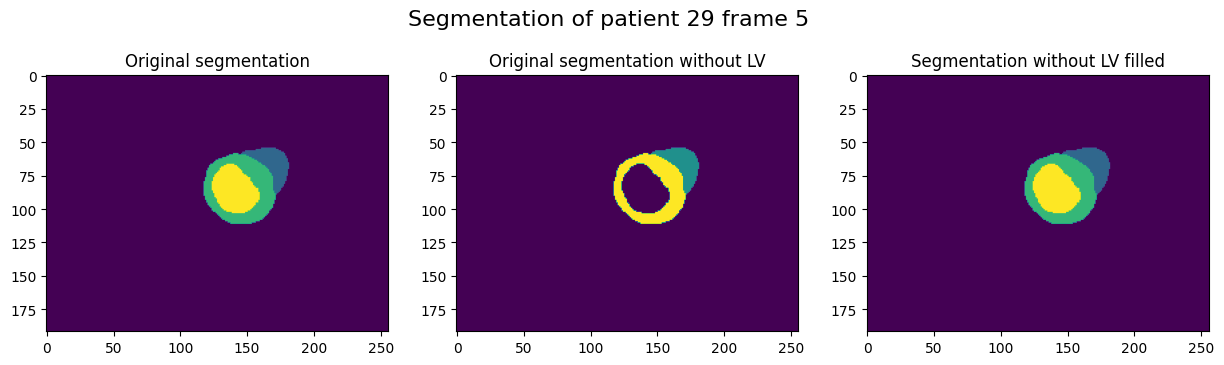

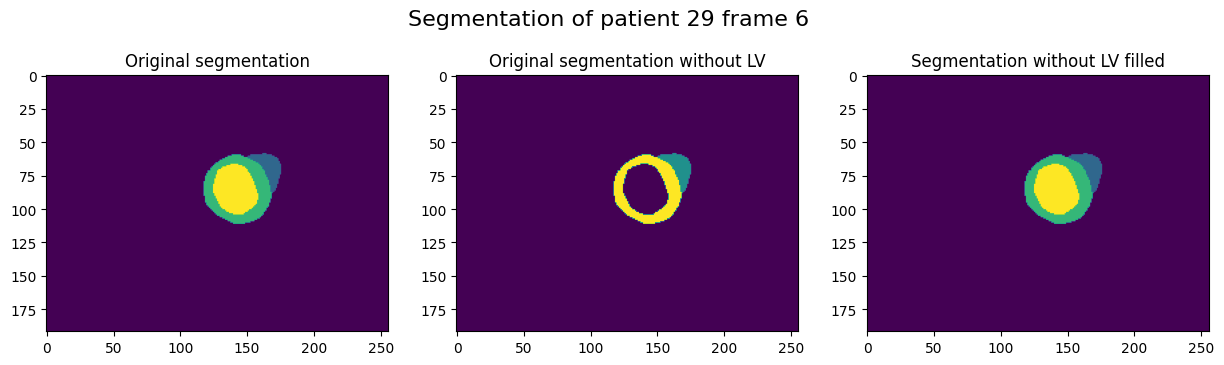

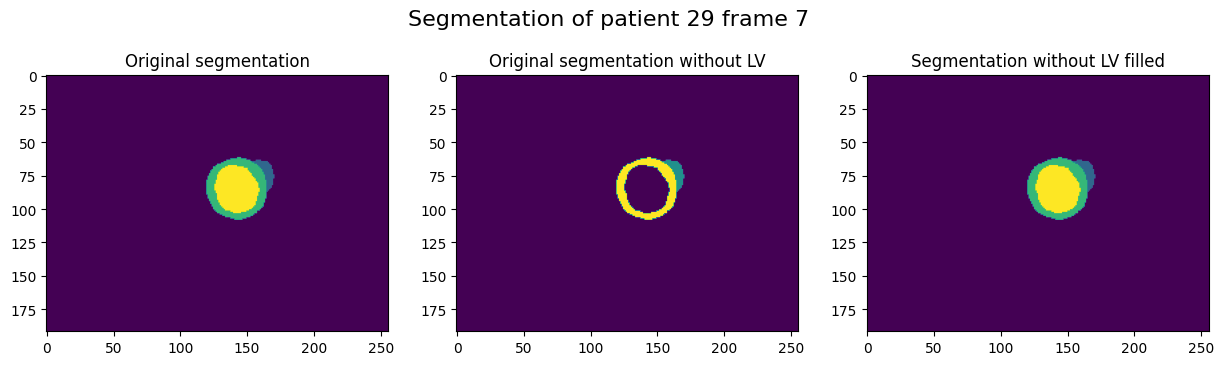

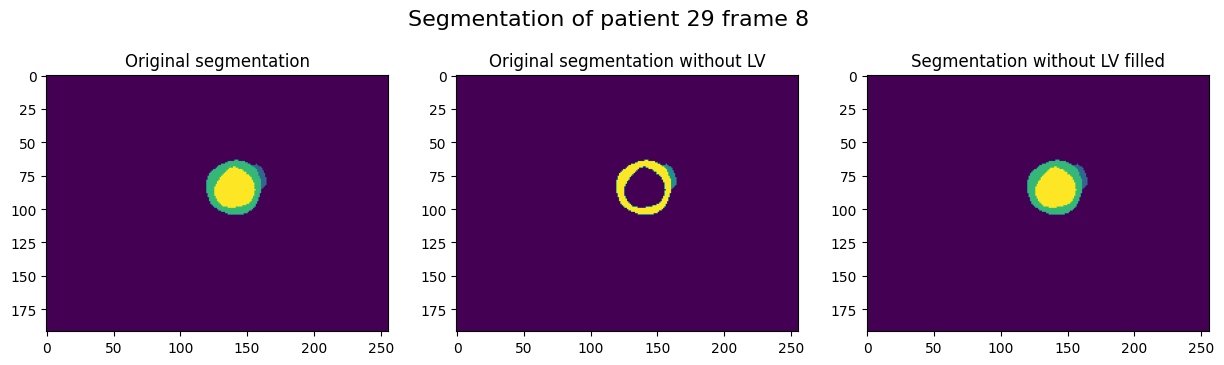

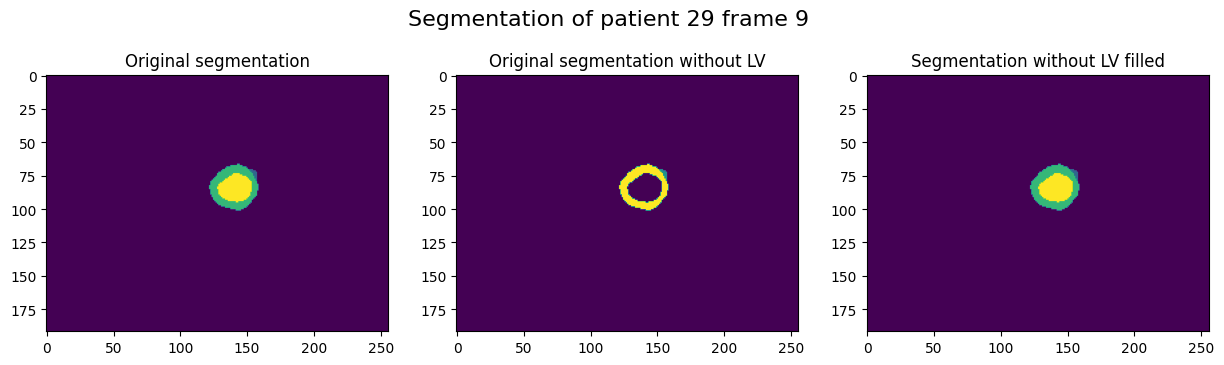

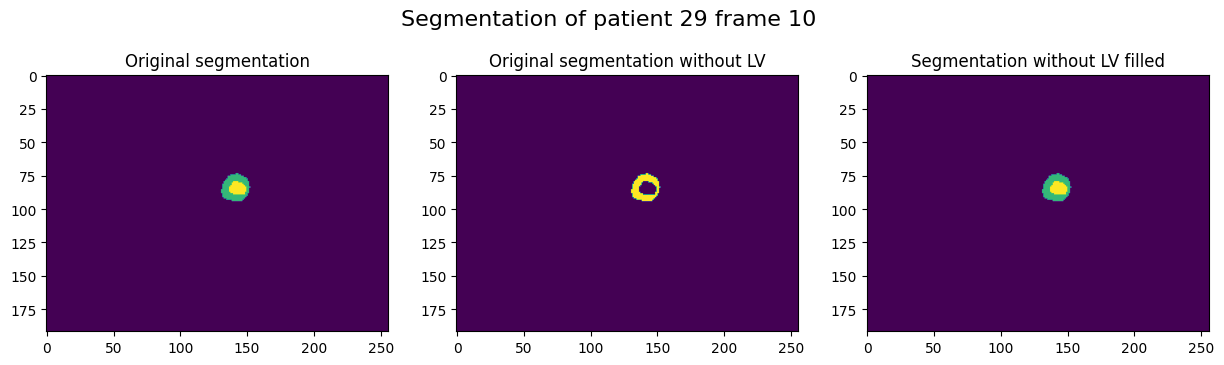

In [25]:
index = 28
for frame in range(ED_seg[index].shape[2]):

    fig, ax = plt.subplots(1, 3, figsize=(15, 4))

    ax[0].imshow(ED_seg[index][:, :, frame], cmap='viridis')
    ax[0].set_title('Original segmentation')
    ax[2].imshow(new_ED_seg[index][:, :, frame], cmap='viridis')
    ax[2].set_title('Segmentation without LV filled')
    ax[1].imshow(ED_segWithoutLV[index][:, :, frame], cmap='viridis')
    ax[1].set_title('Original segmentation without LV')

    fig.suptitle(f'Segmentation of patient {index+1} frame {frame}', fontsize=16)
    plt.show()

In [26]:
#segmenting the LV in the test data
ED_seg = testData["ED"]["seg"]
dataLVsegmentation(ED_seg)

ES_seg = testData["ES"]["seg"]
dataLVsegmentation(ES_seg)


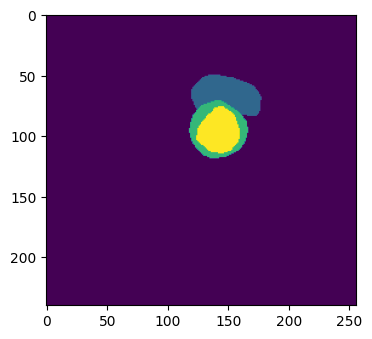

In [27]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(ED_seg[10][:, :, 1], cmap='viridis')
plt.show()


### Fill submission csv

In [28]:
def fillSubmissionFile(categories, path='Dataset/SampleSubmission.csv'):
    """Write the content of the categories list in the submission file

    Args:
        categories (list): Categories' labels, ids associated start at 101 and end at 150
        path (str): path to the submission file

    Returns:
        None
    """
    data = {"Id": [i for i in range(101, 151)], "Category": categories} 
    df = pd.DataFrame(data)
    df.to_csv(path, index=False)
    
    return None

In [29]:
#testing the function
Categories = [i for i in range(1, 51)]
fillSubmissionFile(Categories)

## Preprocessing

## Deleting and filling the LV or not deleting it

This part aims at evaluating the performances of the model with or without the LV completion

In [30]:
completion = False

if completion:
    #deleting LV
    ED_seg = trainData["ED"]["seg"]
    ED_segWithoutLV = deleteLV(ED_seg)

    ES_seg = trainData["ES"]["seg"]
    ES_segWithoutLV = deleteLV(ES_seg)

    #segmenting LV
    new_ED_seg = [np.copy(im) for im in ED_segWithoutLV]
    new_ES_seg = [np.copy(im) for im in ES_segWithoutLV]
    dataLVsegmentation(new_ED_seg)
    dataLVsegmentation(new_ES_seg)

    trainData["ED"]["seg"] = new_ED_seg
    trainData["ES"]["seg"] = new_ES_seg


### Definition of the features functions

In [31]:
ED_seg_metadata = trainData["ED"]["seg_metadata"]
ES_seg_metadata = trainData["ES"]["seg_metadata"]


In [32]:
print(ED_seg_metadata[0])

def voxelVolume(metadata):
    """Extract the voxel volume from the metadata (in mm)

    Args:
        metadata (list): list of metadata

    Returns:
        list: list of voxel sizes
    """
    voxel_volume = []
    for meta in metadata:
        voxel_dimensions = meta.get_zooms()
        voxel_volume.append(np.prod(voxel_dimensions))
        
        
    return np.array(voxel_volume)

#extracting voxel size
ED_voxel_volumes = voxelVolume(ED_seg_metadata)
trainData["ED"]["voxel_volume"] = ED_voxel_volumes

ES_voxel_volumes = voxelVolume(ES_seg_metadata)
trainData["ES"]["voxel_volume"] = ES_voxel_volumes

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 216 256  10   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint8
bitpix          : 8
slice_start     : 0
pixdim          : [ 1.      1.5625  1.5625 10.      1.      1.      1.      1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : 

In [33]:
print(np.unique(trainData["ED"]["voxel_volume"]))
print(np.unique(trainData["ES"]["voxel_volume"]))

[ 4.9438477  6.9444394  7.384528   9.346043  12.207031  13.642052
 14.106792  14.157228  15.625     15.9438    17.089844  17.313034
 18.692017  18.692085  19.77539   20.88921   20.889282  21.267263
 22.033691  22.03384   23.952614  24.414062  26.91634   26.916504
 28.213501  28.213585  30.89896   30.899048  31.8876    35.15625  ]
[ 4.9438477  6.9444394  7.384528   9.346043  12.207031  13.642052
 14.106792  14.157228  15.625     15.9438    17.089844  17.313034
 18.692017  18.692085  19.77539   20.88921   20.889282  21.267263
 22.033691  22.03384   23.952614  24.414062  26.91634   26.916504
 28.213501  28.213585  30.89896   30.899048  31.8876    35.15625  ]


In [34]:
def getVolumes(segmentations, voxel_volumes):
    """Compute the volumes of the different regions in the segmentation

    Args:
        segmentations (list): list of segmentations
        voxel_volume (list): list of voxel volumes

    Returns:
        tuple: volumes of the RV, Myocardium and LV
    """
    RV_volumes = []
    MYO_volumes = []
    LV_volumes = []
    
    for seg, voxel in zip(segmentations, voxel_volumes):
        RV_volumes.append(np.sum(seg == RV)*voxel)
        MYO_volumes.append(np.sum(seg == MYO)*voxel)
        LV_volumes.append(np.sum(seg == LV)*voxel)
        
    return np.array(RV_volumes), np.array(MYO_volumes), np.array(LV_volumes)

#computing volumes
RV_volumes_ED, MYO_volumes_ED, LV_volumes_ED = getVolumes(trainData["ED"]["seg"], trainData["ED"]["voxel_volume"])
RV_volumes_ES, MYO_volumes_ES, LV_volumes_ES = getVolumes(trainData["ES"]["seg"], trainData["ES"]["voxel_volume"])

trainData["ED"]["RV_volumes"] = RV_volumes_ED
trainData["ED"]["MYO_volumes"] = MYO_volumes_ED
trainData["ED"]["LV_volumes"] = LV_volumes_ED

trainData["ES"]["RV_volumes"] = RV_volumes_ES
trainData["ES"]["MYO_volumes"] = MYO_volumes_ES
trainData["ES"]["LV_volumes"] = LV_volumes_ES

In [35]:
def getEF(diastoleVolumes, systoleVolumes):
    return np.array((diastoleVolumes - systoleVolumes)/diastoleVolumes)

#computing EF
# EF_values = getEF(np.array(LV_volumes_ED) + np.array(MYO_volumes_ED), np.array(LV_volumes_ES) + np.array(MYO_volumes_ES))
EF_LV = getEF(np.array(LV_volumes_ED), np.array(LV_volumes_ES))
EF_RV = getEF(np.array(RV_volumes_ED), np.array(RV_volumes_ES))
trainData["EF_LV"] = EF_LV
trainData["EF_RV"] = EF_RV

In [36]:
def getBSA(height, weight):
    return np.sqrt((height*weight)/3600)

trainData["BSA"] = getBSA(np.array(trainData["height"]), np.array(trainData["weight"]))

def volumeByBSA(volumes, BSA):
    return volumes/BSA


trainData["ED"]["MYO_volume_by_BSA"] = volumeByBSA(trainData["ED"]["MYO_volumes"], trainData["BSA"])
trainData["ES"]["MYO_volume_by_BSA"] = volumeByBSA(trainData["ES"]["MYO_volumes"], trainData["BSA"])

trainData["ED"]["LV_volume_by_BSA"] = volumeByBSA(trainData["ED"]["LV_volumes"], trainData["BSA"])
trainData["ES"]["LV_volume_by_BSA"] = volumeByBSA(trainData["ES"]["LV_volumes"], trainData["BSA"])

trainData["ED"]["RV_volume_by_BSA"] = volumeByBSA(trainData["ED"]["RV_volumes"], trainData["BSA"])
trainData["ES"]["RV_volume_by_BSA"] = volumeByBSA(trainData["ES"]["RV_volumes"], trainData["BSA"])

In [37]:
def getMycardiumMass(volumes, voxel_volumes, density=1.05):
    return np.array(volumes)*np.array(voxel_volumes)*density

trainData["ED"]["MYO_mass"] = getMycardiumMass(MYO_volumes_ED, trainData["ED"]["voxel_volume"])
trainData["ES"]["MYO_mass"] = getMycardiumMass(MYO_volumes_ES, trainData["ES"]["voxel_volume"])

In [38]:
from scipy.ndimage import distance_transform_edt, center_of_mass


def getDistances(layer, anatomicalPart):
    mask = np.copy(layer)
    mask[mask != anatomicalPart] = 0
    mask[mask == anatomicalPart] = 1
    
    center = center_of_mass(mask)
    indices = np.where(mask == 1)
    distances = np.sqrt((indices[0] - center[0])**2 + (indices[1] - center[1])**2)
    # distance_map = distance_transform_edt(mask)
    
    return np.max(distances), np.min(distances)

layer = trainData["ED"]["seg"][0][:, :, 5]

max_distance, min_distance = getDistances(layer, MYO)
print(max_distance, min_distance)

30.828849088068132 21.64577459266588


In [39]:
def getPerimeter(layer, anatomicalPart):
    mask = np.copy(layer)
    mask[mask != anatomicalPart] = 0
    mask[mask == anatomicalPart] = 1
    
    # Convert mask to uint8
    mask = mask.astype(np.uint8)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    perimeter = 0
    if contours:
        perimeter = cv2.arcLength(contours[0], True)
    
    return perimeter

def getMeanMaxPerimeterPerson(personData, anatomicalPart):
    perimeters = []

    for i in range(personData.shape[2]):
        layer = personData[:, :, i]
        perimeter = getPerimeter(layer, anatomicalPart)
        perimeters.append(perimeter)
        
    perimeters = np.array(perimeters)
        
    return np.max(perimeters), np.mean(perimeters)

def getMeanMaxPerimeterData(data, anatomicalPart):
    max_perimeters = []
    mean_perimeters = []
    for person in data:
        max_perimeter, mean_perimeter = getMeanMaxPerimeterPerson(person, anatomicalPart)
        max_perimeters.append(max_perimeter)
        mean_perimeters.append(mean_perimeter)
        
    max_perimeters = np.array(max_perimeters)
    mean_perimeters = np.array(mean_perimeters)
    
    return max_perimeters, mean_perimeters

trainData["ED"]["MYO_max_perimeter"], trainData["ED"]["MYO_mean_perimeter"] = getMeanMaxPerimeterData(trainData["ED"]["seg"], MYO)
trainData["ES"]["MYO_max_perimeter"], trainData["ES"]["MYO_mean_perimeter"] = getMeanMaxPerimeterData(trainData["ES"]["seg"], MYO)

trainData["ED"]["RV_max_perimeter"], trainData["ED"]["RV_mean_perimeter"] = getMeanMaxPerimeterData(trainData["ED"]["seg"], RV)
trainData["ES"]["RV_max_perimeter"], trainData["ES"]["RV_mean_perimeter"] = getMeanMaxPerimeterData(trainData["ES"]["seg"], RV)

print(trainData["ED"]["MYO_max_perimeter"].shape, trainData["ED"]["MYO_mean_perimeter"].shape)
   

(100,) (100,)


In [40]:
def getCircularity(layer, anatomicalPart):
    mask = np.copy(layer)
    mask[mask != anatomicalPart] = 0
    mask[mask == anatomicalPart] = 1
    
    perimeter = getPerimeter(layer, anatomicalPart)
        
    # Calculate area
    area = np.sum(mask)
    
    # Calculate circularity
    circularity = 0
    if perimeter != 0:
        circularity = 4*np.pi*area/perimeter**2
        
    return circularity


def getMeanCircularityPerson(personData, anatomicalPart):
    circularities = []
    for i in range(personData.shape[2]):
        layer = personData[:, :, i]
        circularities.append(getCircularity(layer, anatomicalPart))
    return np.mean(circularities)
    

def getMeanCircularity(data, anatomicalPart):
    circularities = []
    for person in data:
        circularity = getMeanCircularityPerson(person, anatomicalPart)
        circularities.append(circularity)
    return np.array(circularities)


layer = trainData["ED"]["seg"][0][:, :, 5]
circularity = getCircularity(layer, MYO)
print(circularity)

personData = trainData["ED"]["seg"][0]
mean_circularity = getMeanCircularityPerson(personData, MYO)
print(mean_circularity)

meanCircularity = getMeanCircularity(trainData["ED"]["seg"], MYO)
trainData["ED"]["MYO_mean_circularity"] = np.array(meanCircularity)

meanCircularity = getMeanCircularity(trainData["ES"]["seg"], MYO)
trainData["ES"]["MYO_mean_circularity"] = np.array(meanCircularity)

meanCircularity = getMeanCircularity(trainData["ED"]["seg"], RV)
trainData["ED"]["RV_mean_circularity"] = np.array(meanCircularity)

meanCircularity = getMeanCircularity(trainData["ES"]["seg"], RV)
trainData["ES"]["RV_mean_circularity"] = np.array(meanCircularity)

print(trainData["ED"]["MYO_mean_circularity"].shape, trainData["ES"]["MYO_mean_circularity"].shape)

0.32778160868363804
0.30146094979346705
(100,) (100,)


In [41]:
def getMyocardThickness(frame):
    mask = np.copy(frame)
    mask[mask != MYO] = 0
    mask[mask == MYO] = 1

    # Convert mask to uint8
    mask = mask.astype(np.uint8)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Trier les contours par taille, le plus grand est le contour externe
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    if len(contours) < 2:
        # raise ValueError("Le masque doit contenir au moins deux contours : interne et externe.")
        return []

    # Contour externe et interne
         
    inner_contour = contours[0]
    outer_contour = contours[1]

    # Calculer les distances entre les contours
    thicknesses = []
    for point in inner_contour:
        # point = point[0]
        pt = (int(point[0][0]), int(point[0][1]))
        dist = cv2.pointPolygonTest(outer_contour, pt, True)
        thicknesses.append(abs(dist))

    # Retourner l'épaisseur moyenne
    return thicknesses

def getThicknessPersonData(personData):
    thicknesses = []
    for i in range(personData.shape[2]):
        layer = personData[:, :, i]
        thicknesses += getMyocardThickness(layer)
        
    return np.min(thicknesses), np.mean(thicknesses), np.max(thicknesses), np.std(thicknesses)

def getThicknessData(data):
    min_thicknesses = []
    mean_thicknesses = []
    max_thicknesses = []
    std_thicknesses = []
    for person in data:
        min_thickness, mean_thickness, max_thickness, std_thickness = getThicknessPersonData(person)
        min_thicknesses.append(min_thickness)
        mean_thicknesses.append(mean_thickness)
        max_thicknesses.append(max_thickness)
        std_thicknesses.append(std_thickness)
        
    return np.array(min_thicknesses), np.array(mean_thicknesses), np.array(max_thicknesses), np.array(std_thicknesses)




frame = trainData["ED"]["seg"][0][:, :, 5]
dataPerson = trainData["ED"]["seg"][0]

print(dataPerson.shape)
min_thickness, mean_thickness, max_thickness, std_thickness = getThicknessPersonData(dataPerson)
print(min_thickness, mean_thickness, max_thickness, std_thickness)



min_thickness_ED, mean_thickness_ED, max_thickness_ED, std_thickness_ED = getThicknessData(trainData["ED"]["seg"])
min_thickness_ES, mean_thickness_ES, max_thickness_ES, std_thickness_ES = getThicknessData(trainData["ES"]["seg"])

trainData["ED"]["MYO_thickness_min"] = min_thickness_ED
trainData["ES"]["MYO_thickness_min"] = min_thickness_ES

trainData["ED"]["MYO_thickness_mean"] = mean_thickness_ED
trainData["ES"]["MYO_thickness_mean"] = mean_thickness_ES

trainData["ED"]["MYO_thickness_max"] = max_thickness_ED
trainData["ES"]["MYO_thickness_max"] = max_thickness_ES

trainData["ED"]["MYO_thickness_std"] = std_thickness_ED
trainData["ES"]["MYO_thickness_std"] = std_thickness_ES




(216, 256, 10)
1.4142135623730951 4.167967760843706 7.211102550927978 0.9197230038068437


### Defining the features

In [42]:
import pandas as pd

features = {}

# FEATURES  of papier Densely Connected Fully Convolutional
# Network for Short-Axis Cardiac Cine MR
# Image Segmentation and Heart Diagnosis

features["ED_RV_volumes"] = trainData["ED"]["RV_volumes"]
features["ED_LV_volumes"] = trainData["ED"]["LV_volumes"]
features["ES_RV_volumes"] = trainData["ES"]["RV_volumes"]
features["ES_MYO_volumes"] = trainData["ES"]["MYO_volumes"]
features["ES_LV_volumes"] = trainData["ES"]["LV_volumes"]
features["EF_LV"] = trainData["EF_LV"]
features["EF_RV"] = trainData["EF_RV"]
features["ED_MYO_mass"] = trainData["ED"]["MYO_mass"]
features["height"] = trainData["height"]
features["weight"] = trainData["weight"]

# Supplementary features Automatic Segmentation and Disease
# Classification Using Cardiac Cine MR

features["ED_MYO_volumes"] = trainData["ED"]["MYO_volumes"]
features["ES_MYO_volumes"] = trainData["ES"]["MYO_volumes"]

features["ED_RV_volumes_div_ED_LV_volumes"] = trainData["ED"]["RV_volumes"] / trainData["ED"]["LV_volumes"]
features["ES_RV_volumes_div_ED_LV_volumes"] = trainData["ES"]["RV_volumes"] / trainData["ED"]["LV_volumes"]
features["ED_MYO_volumes_div_ED_LV_volumes"] = trainData["ED"]["MYO_volumes"] / trainData["ED"]["LV_volumes"]
features["ES_MYO_volumes_div_ES_LV_volumes"] = trainData["ES"]["MYO_volumes"] / trainData["ES"]["LV_volumes"]
features["ED_MYO_volumes_div_ES_LV_volumes"] = trainData["ED"]["MYO_volumes"] / trainData["ES"]["LV_volumes"]

features["ED_RV_mean_circularity"] = trainData["ED"]["RV_mean_circularity"]
features["ES_RV_mean_circularity"] = trainData["ES"]["RV_mean_circularity"]
features["ED_MYO_mean_circularity"] = trainData["ED"]["MYO_mean_circularity"]
features["ES_MYO_mean_circularity"] = trainData["ES"]["MYO_mean_circularity"]

features["ED_RV_max_perimeter"] = trainData["ED"]["RV_max_perimeter"]
features["ES_RV_max_perimeter"] = trainData["ES"]["RV_max_perimeter"]
features["ED_RV_mean_perimeter"] = trainData["ED"]["RV_mean_perimeter"]
features["ES_RV_mean_perimeter"] = trainData["ES"]["RV_mean_perimeter"]
features["ED_MYO_max_perimeter"] = trainData["ED"]["MYO_max_perimeter"]
features["ES_MYO_max_perimeter"] = trainData["ES"]["MYO_max_perimeter"]
features["ED_MYO_mean_perimeter"] = trainData["ED"]["MYO_mean_perimeter"]
features["ES_MYO_mean_perimeter"] = trainData["ES"]["MYO_mean_perimeter"]

features["ED_RV_volume_by_BSA"] = trainData["ED"]["RV_volume_by_BSA"]
features["ES_RV_volume_by_BSA"] = trainData["ES"]["RV_volume_by_BSA"]
features["ED_MYO_volume_by_BSA"] = trainData["ED"]["MYO_volume_by_BSA"]
features["ES_MYO_volume_by_BSA"] = trainData["ES"]["MYO_volume_by_BSA"]
features["ED_LV_volume_by_BSA"] = trainData["ED"]["LV_volume_by_BSA"]
features["ES_LV_volume_by_BSA"] = trainData["ES"]["LV_volume_by_BSA"]

features["ED_MYO_thickness_min"] = trainData["ED"]["MYO_thickness_min"]
features["ES_MYO_thickness_min"] = trainData["ES"]["MYO_thickness_min"]
features["ED_MYO_thickness_mean"] = trainData["ED"]["MYO_thickness_mean"]
features["ES_MYO_thickness_mean"] = trainData["ES"]["MYO_thickness_mean"]
features["ED_MYO_thickness_max"] = trainData["ED"]["MYO_thickness_max"]
features["ES_MYO_thickness_max"] = trainData["ES"]["MYO_thickness_max"]
features["ED_MYO_thickness_std"] = trainData["ED"]["MYO_thickness_std"]
features["ES_MYO_thickness_std"] = trainData["ES"]["MYO_thickness_std"]

# Ensuite transforme en DataFrame directement
features = pd.DataFrame(features)

print(features.head())


   ED_RV_volumes  ED_LV_volumes  ES_RV_volumes  ES_MYO_volumes  ES_LV_volumes  \
0  139721.679688  295507.812500   59545.898438   195068.359375  225610.351562   
1   94432.067871  265744.400024   28823.089600   192565.155029  188303.375244   
2  192333.984375  276708.984375  174584.960938   201074.218750  241088.867188   
3  106264.114380  260847.091675   84543.991089   174957.275391  226472.473145   
4  170463.867188  290797.119141   74553.222656   232261.962891  224094.726562   

      EF_LV     EF_RV   ED_MYO_mass  height  weight  ...  ED_LV_volume_by_BSA  \
0  0.236533  0.573825  4.210711e+06   184.0    95.0  ...        134106.399682   
1  0.291412  0.694774  3.148768e+06   160.0    70.0  ...        150662.913166   
2  0.128728  0.092282  4.917920e+06   165.0    77.0  ...        147294.718929   
3  0.131781  0.204398  3.306152e+06   159.0    46.0  ...        183003.658210   
4  0.229378  0.562645  4.181748e+06   165.0    77.0  ...        154793.961700   

   ES_LV_volume_by_BSA  ED

In [43]:
import numpy as np


# Function to check if a value is numeric
def is_numeric(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

# Check for non-numeric values
non_numeric_found = False
for row in features.columns:
    for element in features[row]:
        if not is_numeric(element):
            non_numeric_found = True
            print(f"Non-numeric value found: {element}")
            break
    if non_numeric_found:
        break

if not non_numeric_found:
    print("All values in trainFeatures are numeric.")


All values in trainFeatures are numeric.


## Splitting features into train/validation and test set

In [107]:
from sklearn.model_selection import train_test_split
X = features
y = np.array(trainData["category"])
class_names = ["NOR", "MINF", "DCM", "HCM", "RV"]

X_train, X_test, y_train, y_test = train_test_split(
    features, y, test_size=0.1, stratify=y
)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(90, 42) (10, 42) (90,) (10,)


# Training models

### training a Random Forest

meilleurs hyperparamètres trouvés:

{'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}

In [108]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print(X_train_scaled.shape, X_test_scaled.shape)


(90, 42) (10, 42)


In [109]:
from sklearn.decomposition import PCA

# Apply PCA with a variance threshold (e.g. 95%)
variance_threshold = 0.95
pca = PCA(n_components=variance_threshold)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Optionally concatenate PCA components with original features
pca_columns = [f'pca{i+1}' for i in range(X_train_pca.shape[1])]

X_train_pca_df = pd.DataFrame(X_train_pca, columns=pca_columns)
X_test_pca_df = pd.DataFrame(X_test_pca, columns=pca_columns)

X_train_scaled_and_pca = pd.concat([X_train_scaled.reset_index(drop=True), X_train_pca_df], axis=1)
X_test_scaled_and_pca = pd.concat([X_test_scaled.reset_index(drop=True), X_test_pca_df], axis=1)

print(X_train_scaled_and_pca.shape, X_test_scaled_and_pca.shape)

(90, 53) (10, 53)


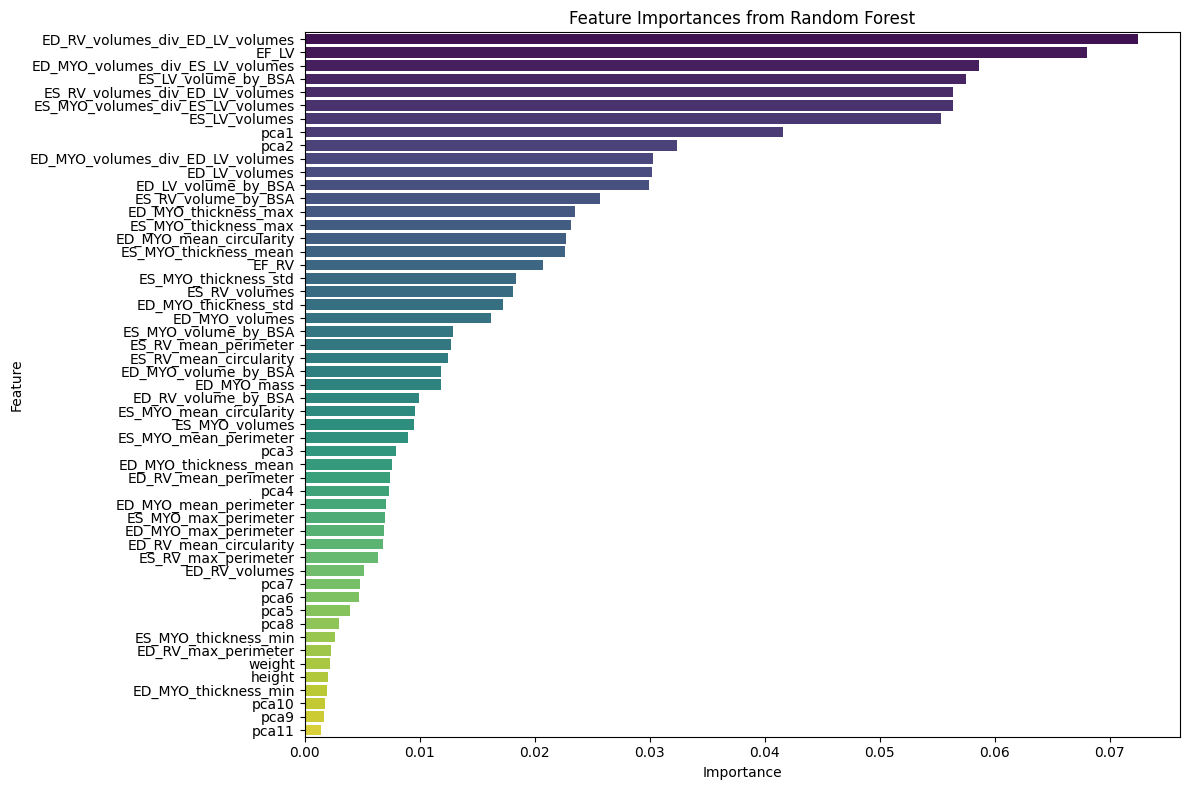

In [113]:
compute_importance = True
if compute_importance:

    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.ensemble import RandomForestClassifier

    from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
    from sklearn.feature_selection import SelectFromModel
    from sklearn.metrics import confusion_matrix, classification_report





    # Sélection des features avec RandomForest
    rf = RandomForestClassifier(n_estimators=10000, min_samples_leaf=1, min_samples_split=2)
    rf.fit(X_train_scaled_and_pca, y_train)


    importances = rf.feature_importances_

    feature_names = X_train_scaled_and_pca.columns

    # Combine feature names and importances
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot all feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance_df, x='Importance', y='Feature', hue='Feature', palette='viridis')
    plt.title('Feature Importances from Random Forest')
    plt.tight_layout()
    plt.show()

In [114]:
from sklearn.feature_selection import SelectFromModel

# Sélection automatique des features importantes
selector = SelectFromModel(rf, threshold="mean", prefit=True)  # modèle déjà entraîné

# Réduction du jeu de données
X_train_selected = selector.transform(X_train_scaled_and_pca)
X_test_selected = selector.transform(X_test_scaled_and_pca)

# Récupérer les noms des features sélectionnées
selected_features_mask = selector.get_support()
selected_feature_names = X_train_scaled_and_pca.columns[selected_features_mask]

print(f"{len(selected_feature_names)} features sélectionnées sur {X_train_scaled.shape[1]}")
print("Features sélectionnées :", list(selected_feature_names))






c:\Users\quent\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
c:\Users\quent\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


18 features sélectionnées sur 42
Features sélectionnées : ['ED_LV_volumes', 'ES_LV_volumes', 'EF_LV', 'EF_RV', 'ED_RV_volumes_div_ED_LV_volumes', 'ES_RV_volumes_div_ED_LV_volumes', 'ED_MYO_volumes_div_ED_LV_volumes', 'ES_MYO_volumes_div_ES_LV_volumes', 'ED_MYO_volumes_div_ES_LV_volumes', 'ED_MYO_mean_circularity', 'ES_RV_volume_by_BSA', 'ED_LV_volume_by_BSA', 'ES_LV_volume_by_BSA', 'ES_MYO_thickness_mean', 'ED_MYO_thickness_max', 'ES_MYO_thickness_max', 'pca1', 'pca2']


In [115]:
# feature_indices_sorted = np.argsort(importances)[::-1]  # tri décroissant
# print(feature_indices_sorted)
# k = 20


# top_k_indices = feature_indices_sorted[:k]
# X_train_selected = np.array(X_train_scaled_and_pca)[:, top_k_indices]
# X_test_selected = np.array(X_test_scaled_and_pca)[:, top_k_indices]

Meilleurs hyperparamètres : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        18
           1       0.83      0.83      0.83        18
           2       0.88      0.83      0.86        18
           3       0.94      0.94      0.94        18
           4       1.00      0.89      0.94        18

    accuracy                           0.90        90
   macro avg       0.90      0.90      0.90        90
weighted avg       0.90      0.90      0.90        90



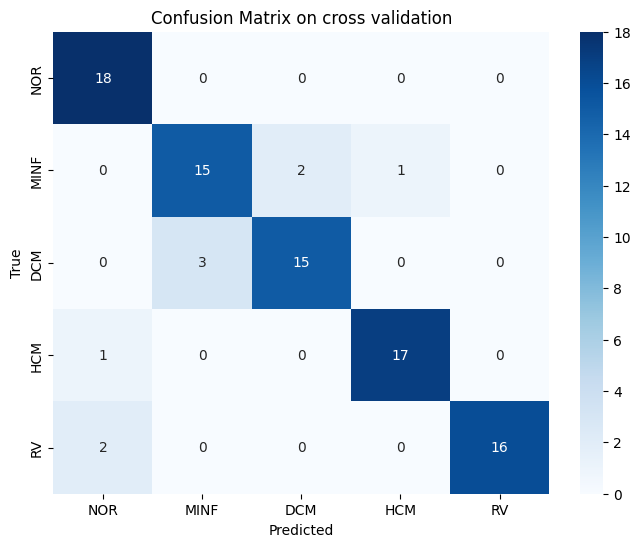

Cross-validation accuracy scores: [0.88888889 1.         0.83333333 0.94444444 0.83333333]
Variance of accuracy: 0.004197530864197529


In [116]:


# selector = SelectFromModel(rf, prefit=True)
# features_selected = selector.transform(features_scaled)



# Définition des hyperparamètres à optimiser
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


# Optimisation des hyperparamètres avec RandomizedSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True)
rf_tuned = RandomForestClassifier(criterion='entropy')
random_search = GridSearchCV(rf_tuned, param_grid=param_dist, 
                                   cv=cv, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train_selected, y_train)

# Meilleurs paramètres trouvés
best_params_rf = random_search.best_params_
print("Meilleurs hyperparamètres :", best_params_rf)

# Réentraînement du modèle avec les meilleurs hyperparamètres
best_rf = RandomForestClassifier(**best_params_rf)
y_pred_rf = cross_val_predict(best_rf, X_train_selected, y_train, cv=cv)

# Matrice de confusion et rapport de classification
conf_matrix = confusion_matrix(y_train, y_pred_rf)
print("Classification Report:")
print(classification_report(y_train, y_pred_rf))

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on cross validation')
plt.show()

# Calculate cross-validation scores
cv_scores = cross_val_score(best_rf, X_train_selected, y_train, cv=cv, scoring='accuracy')

# Print the variance of the accuracy
print("Cross-validation accuracy scores:", cv_scores)
print("Variance of accuracy:", np.var(cv_scores))

#Meilleurs hyperparamètres : {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

# Predicting on test data

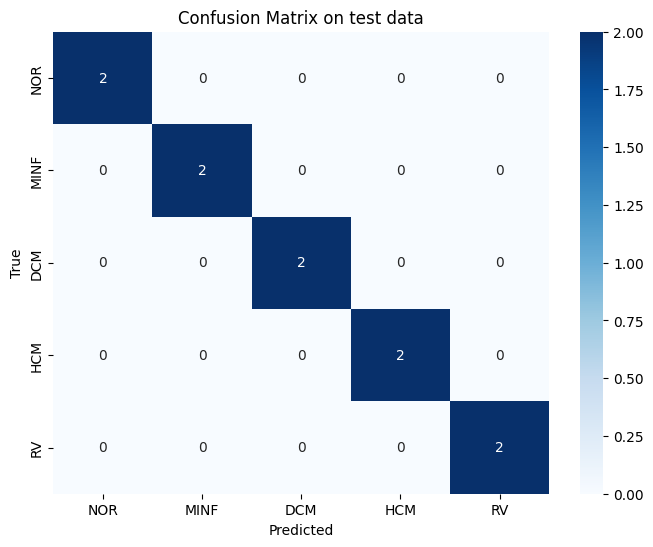

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [117]:
best_rf.fit(X_train_selected, y_train)
predictions = best_rf.predict(X_test_selected)

conf_matrix_test = confusion_matrix(y_test, predictions)



# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on test data')
plt.show()

from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, predictions))



### Training a MLP

I chose scoring=accuracy because classes are not imbalanced.

Meilleurs hyperparamètres pour MLP : {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': False, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.88      0.83      0.86        18
           2       0.89      0.89      0.89        18
           3       0.94      0.94      0.94        18
           4       0.95      1.00      0.97        18

    accuracy                           0.92        90
   macro avg       0.92      0.92      0.92        90
weighted avg       0.92      0.92      0.92        90



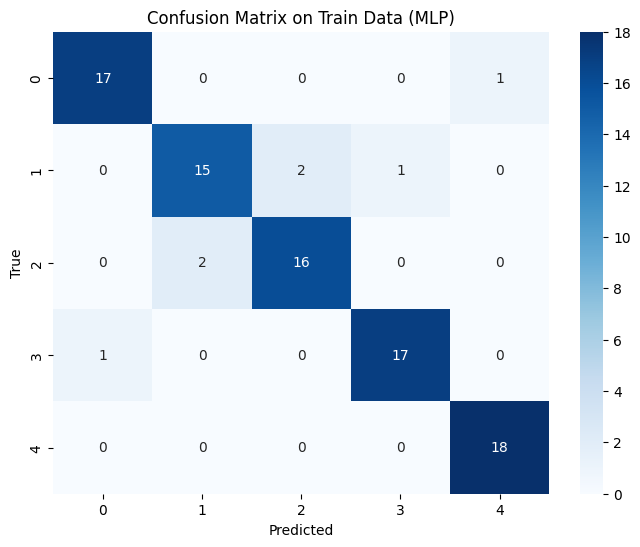

Cross-validation accuracy scores: [1.         0.94444444 0.83333333 1.         0.83333333]
Variance of accuracy: 0.005679012345679009


In [127]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler

# Définition des hyperparamètres à optimiser pour le MLP
param_dist = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],  # L2 regularization
    'learning_rate_init': [0.01],  # Initial learning rate
    'early_stopping': [False]
}

# param_dist = {
#     'hidden_layer_sizes': [(100)],
#     'activation': ['relu'],
#     'solver': ['adam'],
#     'alpha': [0.0001],  # L2 regularization
#     'learning_rate_init': [0.01],  # Initial learning rate
#     'early_stopping': [False]
# }

# Optimisation des hyperparamètres avec GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp_tuned = MLPClassifier(max_iter=10000, random_state=42)
random_search = GridSearchCV(mlp_tuned, param_grid=param_dist, n_jobs=-1, cv=cv, scoring='accuracy')
random_search.fit(X_train_selected, y_train)

# Meilleurs paramètres trouvés
best_params_mlp = random_search.best_params_
print("Meilleurs hyperparamètres pour MLP :", best_params_mlp)

# Réentraînement du modèle avec les meilleurs hyperparamètres
best_mlp = MLPClassifier(**best_params_mlp, max_iter=10000, random_state=42)
y_pred_mlp = cross_val_predict(best_mlp, X_train_selected, y_train, cv=cv)

# Matrice de confusion et rapport de classification sur les données d'entraînement
conf_matrix_train = confusion_matrix(y_train, y_pred_mlp)
print("Classification Report (Train):")
print(classification_report(y_train, y_pred_mlp))

# Affichage de la matrice de confusion pour les données d'entraînement
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Train Data (MLP)')
plt.show()

# Calculer les scores de cross-validation
cv_scores = cross_val_score(best_mlp, X_train_selected, y_train, cv=cv, scoring='accuracy')
print("Cross-validation accuracy scores:", cv_scores)
print("Variance of accuracy:", np.var(cv_scores))

Classification Report (Test):
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2

    accuracy                           0.90        10
   macro avg       0.93      0.90      0.89        10
weighted avg       0.93      0.90      0.89        10



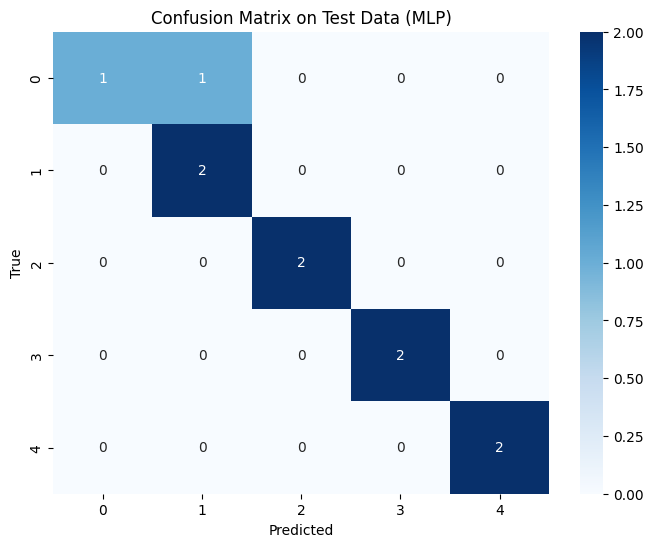

In [128]:
# Réentraînement final sur l'ensemble du training set
best_mlp.fit(X_train_selected, y_train)

# Prédiction sur le test set
predictions = best_mlp.predict(X_test_selected)

# Matrice de confusion et rapport de classification sur le test set
conf_matrix_test = confusion_matrix(y_test, predictions)
print("Classification Report (Test):")
print(classification_report(y_test, predictions))

# Affichage de la matrice de confusion pour le test set
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Test Data (MLP)')
plt.show()

### Taining a SVM


Meilleurs hyperparamètres : {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.93      0.78      0.85        18
           2       0.85      0.94      0.89        18
           3       0.95      1.00      0.97        18
           4       0.95      1.00      0.97        18

    accuracy                           0.93        90
   macro avg       0.94      0.93      0.93        90
weighted avg       0.94      0.93      0.93        90



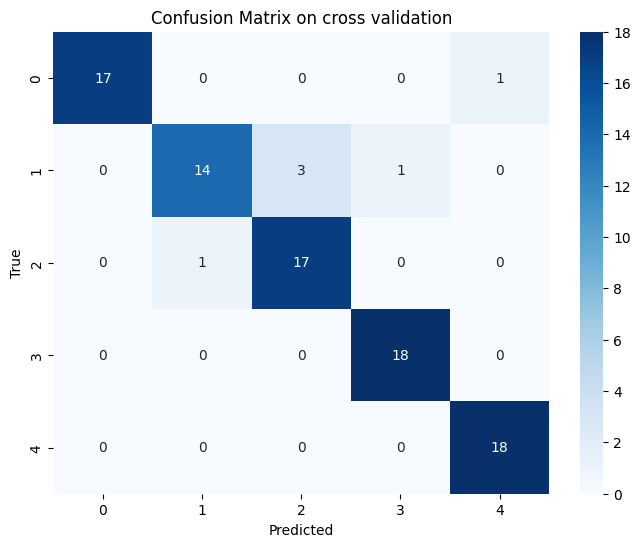

Cross-validation accuracy scores: [0.88888889 1.         0.83333333 0.94444444 1.        ]
Variance of accuracy: 0.00419753086419753


In [129]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Définition des hyperparamètres à optimiser pour SVM
param_dist = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# Optimisation des hyperparamètres avec GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True)
svm_tuned = SVC(probability=True, random_state=42)
grid_search = GridSearchCV(svm_tuned, param_grid=param_dist, 
                           cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Meilleurs paramètres trouvés
best_params_svm = grid_search.best_params_
print("Meilleurs hyperparamètres :", best_params_svm)

# Réentraînement du modèle avec les meilleurs hyperparamètres
best_svm = SVC(**best_params_svm, probability=True)
y_pred_svm = cross_val_predict(best_svm, X_train_selected, y_train, cv=cv)

# Matrice de confusion et rapport de classification
conf_matrix = confusion_matrix(y_train, y_pred_svm)
print("Classification Report:")
print(classification_report(y_train, y_pred_svm))

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on cross validation')
plt.show()

# Calculate cross-validation scores
cv_scores = cross_val_score(best_svm, X_train_selected, y_train, cv=cv, scoring='accuracy')

# Print the variance of the accuracy
print("Cross-validation accuracy scores:", cv_scores)
print("Variance of accuracy:", np.var(cv_scores))

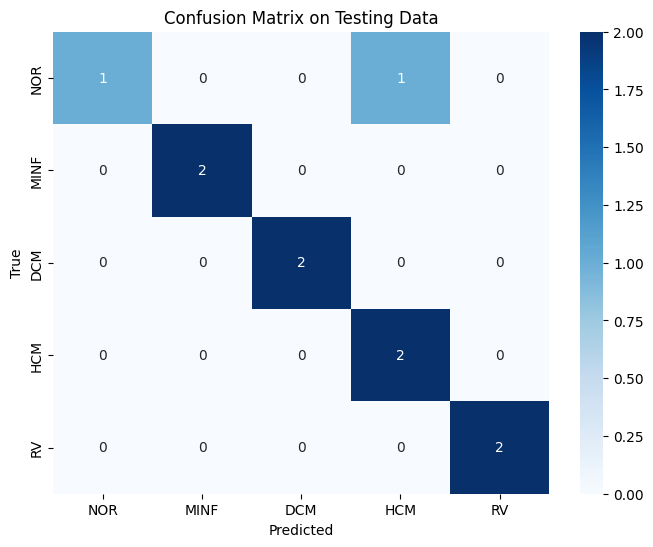

Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         2
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2

    accuracy                           0.90        10
   macro avg       0.93      0.90      0.89        10
weighted avg       0.93      0.90      0.89        10

Testing Accuracy: 0.9000


In [130]:
# Réentraînement sur toutes les données d'entraînement
best_svm = SVC(**best_params_svm, max_iter=10000, random_state=42)
best_svm.fit(X_train_selected, y_train)

# Prédictions sur les données d'entraînement
predictions = best_svm.predict(X_test_selected)

# Matrice de confusion
conf_matrix_test = confusion_matrix(y_test, predictions)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Testing Data')
plt.show()

# Rapport de classification
print("Classification Report (Testing Data):")
print(classification_report(y_test, predictions))

# Précision
train_acc = accuracy_score(y_test, predictions)
print(f"Testing Accuracy: {train_acc:.4f}")

Meilleurs hyperparamètres XGBoost : {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.5}
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.84      0.89      0.86        18
           2       0.89      0.89      0.89        18
           3       1.00      0.94      0.97        18
           4       0.94      0.94      0.94        18

    accuracy                           0.92        90
   macro avg       0.92      0.92      0.92        90
weighted avg       0.92      0.92      0.92        90



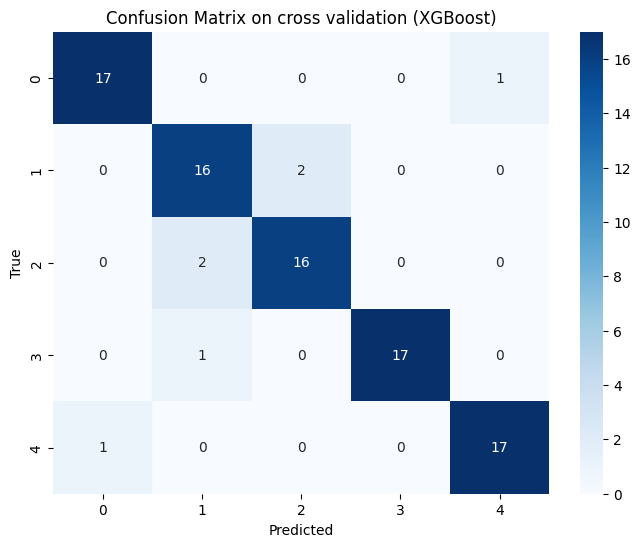

Cross-validation accuracy scores: [0.83333333 0.94444444 1.         0.94444444 0.83333333]
Variance of accuracy: 0.004444444444444442


In [131]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

# Définition des hyperparamètres à optimiser pour XGBoost
param_dist = {
    'n_estimators': [100, 200,500,1000],
    'max_depth': [3, 1],
    'learning_rate': [0.01],
    'subsample': [0.5, 0.3],
    'colsample_bytree': [0.7]
}

# Optimisation des hyperparamètres avec GridSearchCV
cv = StratifiedKFold(n_splits=5, shuffle=True)
xgb_tuned = XGBClassifier(eval_metric='mlogloss')
grid_search = GridSearchCV(xgb_tuned, param_grid=param_dist, 
                           cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_selected, y_train)

# Meilleurs paramètres trouvés
best_params_xgb = grid_search.best_params_
print("Meilleurs hyperparamètres XGBoost :", best_params_xgb)

# Réentraînement du modèle avec les meilleurs hyperparamètres
best_xgb = XGBClassifier(**best_params_xgb, eval_metric='mlogloss')
y_pred_xgb = cross_val_predict(best_xgb, X_train_selected, y_train, cv=cv)

# Matrice de confusion et rapport de classification
conf_matrix = confusion_matrix(y_train, y_pred_xgb)
print("Classification Report:")
print(classification_report(y_train, y_pred_xgb))

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on cross validation (XGBoost)')
plt.show()

# Calculate cross-validation scores
cv_scores = cross_val_score(best_xgb, X_train_selected, y_train, cv=cv, scoring='accuracy')

# Print the variance of the accuracy
print("Cross-validation accuracy scores:", cv_scores)
print("Variance of accuracy:", np.var(cv_scores))


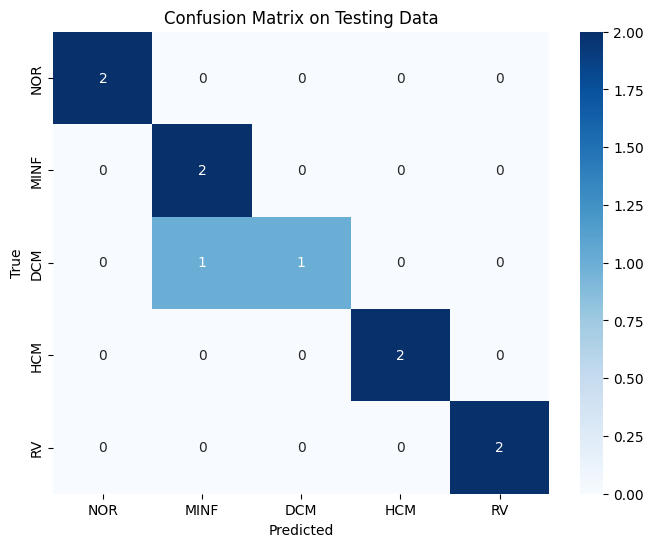

Classification Report (Testing Data):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.67      1.00      0.80         2
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2

    accuracy                           0.90        10
   macro avg       0.93      0.90      0.89        10
weighted avg       0.93      0.90      0.89        10

Testing Accuracy: 0.9000


In [132]:
# Réentraînement sur toutes les données d'entraînement
best_xgb.fit(X_train_selected, y_train)

# Prédictions sur les données d'entraînement
predictions = best_xgb.predict(X_test_selected)

# Matrice de confusion
conf_matrix_test = confusion_matrix(y_test, predictions)

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on Testing Data')
plt.show()

# Rapport de classification
print("Classification Report (Testing Data):")
print(classification_report(y_test, predictions))

# Précision
train_acc = accuracy_score(y_test, predictions)
print(f"Testing Accuracy: {train_acc:.4f}")

### training a voting model

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.83      0.83      0.83        18
           2       0.88      0.83      0.86        18
           3       0.94      0.94      0.94        18
           4       0.90      1.00      0.95        18

    accuracy                           0.91        90
   macro avg       0.91      0.91      0.91        90
weighted avg       0.91      0.91      0.91        90



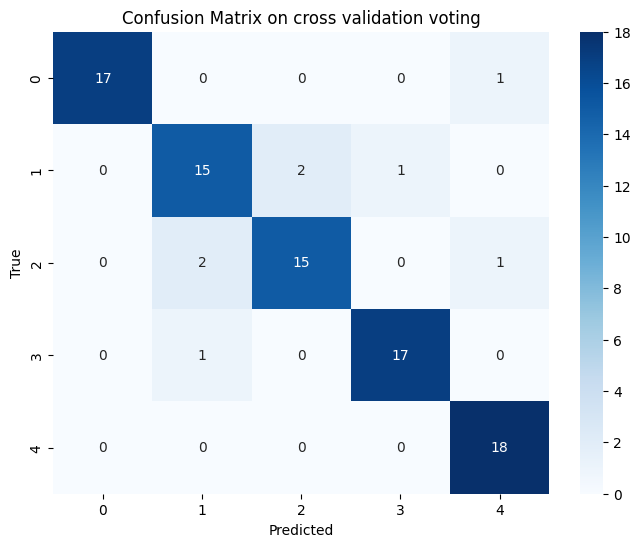

Cross-validation accuracy scores: [0.88888889 0.94444444 1.         0.94444444 0.88888889]
Variance of accuracy: 0.0017283950617283967


In [133]:
from sklearn.ensemble import VotingClassifier

model_vot = VotingClassifier(estimators=[("mlp", best_mlp), ("rf", best_rf),  ('xgb', best_xgb)], voting = "soft")



y_pred_model_vot = cross_val_predict(model_vot, X_train_selected, y_train, cv=cv)

# Matrice de confusion et rapport de classification
conf_matrix = confusion_matrix(y_train, y_pred_model_vot)
print("Classification Report:")
print(classification_report(y_train, y_pred_model_vot))

# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on cross validation voting')
plt.show()

# Calculate cross-validation scores
cv_scores = cross_val_score(model_vot, X_train_selected, y_train, cv=cv, scoring='accuracy')

# Print the variance of the accuracy
print("Cross-validation accuracy scores:", cv_scores)
print("Variance of accuracy:", np.var(cv_scores))



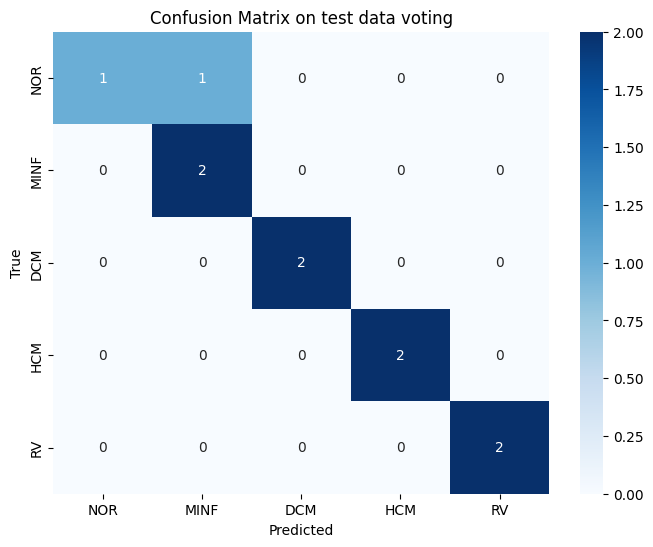

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.67      1.00      0.80         2
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         2

    accuracy                           0.90        10
   macro avg       0.93      0.90      0.89        10
weighted avg       0.93      0.90      0.89        10



In [135]:
model_vot.fit(X_train_selected, y_train)

# Prédictions sur le test set
predictions = model_vot.predict(X_test_selected)

conf_matrix_test = confusion_matrix(y_test, predictions)
# Affichage de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix on test data voting')
plt.show()
print("Classification Report:")
print(classification_report(y_test, predictions))


# Submission

## Preparing data

In [136]:
#LV segmentation
ED_seg = testData["ED"]["seg"]

ES_seg = testData["ES"]["seg"]

#segmenting LV
dataLVsegmentation(ED_seg)
dataLVsegmentation(ES_seg)

testData["ED"]["seg"] = ED_seg
testData["ES"]["seg"] = ES_seg

In [137]:
#definition of features

ED_seg_metadata = testData["ED"]["seg_metadata"]
ES_seg_metadata = testData["ES"]["seg_metadata"]

ED_voxel_volumes = voxelVolume(ED_seg_metadata)
testData["ED"]["voxel_volume"] = ED_voxel_volumes

ES_voxel_volumes = voxelVolume(ES_seg_metadata)
testData["ES"]["voxel_volume"] = ES_voxel_volumes

RV_volumes_ED, MYO_volumes_ED, LV_volumes_ED = getVolumes(testData["ED"]["seg"], testData["ED"]["voxel_volume"])
RV_volumes_ES, MYO_volumes_ES, LV_volumes_ES = getVolumes(testData["ES"]["seg"], testData["ES"]["voxel_volume"])

testData["ED"]["RV_volumes"] = RV_volumes_ED
testData["ED"]["MYO_volumes"] = MYO_volumes_ED
testData["ED"]["LV_volumes"] = LV_volumes_ED

testData["ES"]["RV_volumes"] = RV_volumes_ES
testData["ES"]["MYO_volumes"] = MYO_volumes_ES
testData["ES"]["LV_volumes"] = LV_volumes_ES

EF_LV = getEF(np.array(LV_volumes_ED), np.array(LV_volumes_ES))
EF_RV = getEF(np.array(RV_volumes_ED), np.array(RV_volumes_ES))
testData["EF_LV"] = EF_LV
testData["EF_RV"] = EF_RV

testData["BSA"] = getBSA(np.array(testData["height"]), np.array(testData["weight"]))

testData["ED"]["MYO_volume_by_BSA"] = volumeByBSA(testData["ED"]["MYO_volumes"], testData["BSA"])
testData["ES"]["MYO_volume_by_BSA"] = volumeByBSA(testData["ES"]["MYO_volumes"], testData["BSA"])

testData["ED"]["LV_volume_by_BSA"] = volumeByBSA(testData["ED"]["LV_volumes"], testData["BSA"])
testData["ES"]["LV_volume_by_BSA"] = volumeByBSA(testData["ES"]["LV_volumes"], testData["BSA"])

testData["ED"]["RV_volume_by_BSA"] = volumeByBSA(testData["ED"]["RV_volumes"], testData["BSA"])
testData["ES"]["RV_volume_by_BSA"] = volumeByBSA(testData["ES"]["RV_volumes"], testData["BSA"])

testData["ED"]["MYO_mass"] = getMycardiumMass(MYO_volumes_ED, testData["ED"]["voxel_volume"])
testData["ES"]["MYO_mass"] = getMycardiumMass(MYO_volumes_ES, testData["ES"]["voxel_volume"])

testData["ED"]["MYO_max_perimeter"], testData["ED"]["MYO_mean_perimeter"] = getMeanMaxPerimeterData(testData["ED"]["seg"], MYO)
testData["ES"]["MYO_max_perimeter"], testData["ES"]["MYO_mean_perimeter"] = getMeanMaxPerimeterData(testData["ES"]["seg"], MYO)

testData["ED"]["RV_max_perimeter"], testData["ED"]["RV_mean_perimeter"] = getMeanMaxPerimeterData(testData["ED"]["seg"], RV)
testData["ES"]["RV_max_perimeter"], testData["ES"]["RV_mean_perimeter"] = getMeanMaxPerimeterData(testData["ES"]["seg"], RV)

meanCircularity = getMeanCircularity(testData["ED"]["seg"], MYO)
testData["ED"]["MYO_mean_circularity"] = np.array(meanCircularity)

meanCircularity = getMeanCircularity(testData["ES"]["seg"], MYO)
testData["ES"]["MYO_mean_circularity"] = np.array(meanCircularity)

meanCircularity = getMeanCircularity(testData["ED"]["seg"], RV)
testData["ED"]["RV_mean_circularity"] = np.array(meanCircularity)

meanCircularity = getMeanCircularity(testData["ES"]["seg"], RV)
testData["ES"]["RV_mean_circularity"] = np.array(meanCircularity)

min_thickness_ED, mean_thickness_ED, max_thickness_ED, std_thickness_ED = getThicknessData(testData["ED"]["seg"])
min_thickness_ES, mean_thickness_ES, max_thickness_ES, std_thickness_ES = getThicknessData(testData["ES"]["seg"])

testData["ED"]["MYO_thickness_min"] = min_thickness_ED
testData["ES"]["MYO_thickness_min"] = min_thickness_ES

testData["ED"]["MYO_thickness_mean"] = mean_thickness_ED
testData["ES"]["MYO_thickness_mean"] = mean_thickness_ES

testData["ED"]["MYO_thickness_max"] = max_thickness_ED
testData["ES"]["MYO_thickness_max"] = max_thickness_ES

testData["ED"]["MYO_thickness_std"] = std_thickness_ED
testData["ES"]["MYO_thickness_std"] = std_thickness_ES

In [138]:
import pandas as pd

testFeatures = {}

# FEATURES  of papier Densely Connected Fully Convolutional
# Network for Short-Axis Cardiac Cine MR
# Image Segmentation and Heart Diagnosis

testFeatures["ED_RV_volumes"] = testData["ED"]["RV_volumes"]
testFeatures["ED_LV_volumes"] = testData["ED"]["LV_volumes"]
testFeatures["ES_RV_volumes"] = testData["ES"]["RV_volumes"]
testFeatures["ES_MYO_volumes"] = testData["ES"]["MYO_volumes"]
testFeatures["ES_LV_volumes"] = testData["ES"]["LV_volumes"]
testFeatures["EF_LV"] = testData["EF_LV"]
testFeatures["EF_RV"] = testData["EF_RV"]
testFeatures["ED_MYO_mass"] = testData["ED"]["MYO_mass"]
testFeatures["height"] = testData["height"]
testFeatures["weight"] = testData["weight"]

# Supplementary features Automatic Segmentation and Disease
# Classification Using Cardiac Cine MR

testFeatures["ED_MYO_volumes"] = testData["ED"]["MYO_volumes"]
testFeatures["ES_MYO_volumes"] = testData["ES"]["MYO_volumes"]

testFeatures["ED_RV_volumes_div_ED_LV_volumes"] = testData["ED"]["RV_volumes"] / testData["ED"]["LV_volumes"]
testFeatures["ES_RV_volumes_div_ED_LV_volumes"] = testData["ES"]["RV_volumes"] / testData["ED"]["LV_volumes"]
testFeatures["ED_MYO_volumes_div_ED_LV_volumes"] = testData["ED"]["MYO_volumes"] / testData["ED"]["LV_volumes"]
testFeatures["ES_MYO_volumes_div_ES_LV_volumes"] = testData["ES"]["MYO_volumes"] / testData["ES"]["LV_volumes"]
testFeatures["ED_MYO_volumes_div_ES_LV_volumes"] = testData["ED"]["MYO_volumes"] / testData["ES"]["LV_volumes"]

testFeatures["ED_RV_mean_circularity"] = testData["ED"]["RV_mean_circularity"]
testFeatures["ES_RV_mean_circularity"] = testData["ES"]["RV_mean_circularity"]
testFeatures["ED_MYO_mean_circularity"] = testData["ED"]["MYO_mean_circularity"]
testFeatures["ES_MYO_mean_circularity"] = testData["ES"]["MYO_mean_circularity"]

testFeatures["ED_RV_max_perimeter"] = testData["ED"]["RV_max_perimeter"]
testFeatures["ES_RV_max_perimeter"] = testData["ES"]["RV_max_perimeter"]
testFeatures["ED_RV_mean_perimeter"] = testData["ED"]["RV_mean_perimeter"]
testFeatures["ES_RV_mean_perimeter"] = testData["ES"]["RV_mean_perimeter"]
testFeatures["ED_MYO_max_perimeter"] = testData["ED"]["MYO_max_perimeter"]
testFeatures["ES_MYO_max_perimeter"] = testData["ES"]["MYO_max_perimeter"]
testFeatures["ED_MYO_mean_perimeter"] = testData["ED"]["MYO_mean_perimeter"]
testFeatures["ES_MYO_mean_perimeter"] = testData["ES"]["MYO_mean_perimeter"]

testFeatures["ED_RV_volume_by_BSA"] = testData["ED"]["RV_volume_by_BSA"]
testFeatures["ES_RV_volume_by_BSA"] = testData["ES"]["RV_volume_by_BSA"]
testFeatures["ED_MYO_volume_by_BSA"] = testData["ED"]["MYO_volume_by_BSA"]
testFeatures["ES_MYO_volume_by_BSA"] = testData["ES"]["MYO_volume_by_BSA"]
testFeatures["ED_LV_volume_by_BSA"] = testData["ED"]["LV_volume_by_BSA"]
testFeatures["ES_LV_volume_by_BSA"] = testData["ES"]["LV_volume_by_BSA"]

testFeatures["ED_MYO_thickness_min"] = testData["ED"]["MYO_thickness_min"]
testFeatures["ES_MYO_thickness_min"] = testData["ES"]["MYO_thickness_min"]
testFeatures["ED_MYO_thickness_mean"] = testData["ED"]["MYO_thickness_mean"]
testFeatures["ES_MYO_thickness_mean"] = testData["ES"]["MYO_thickness_mean"]
testFeatures["ED_MYO_thickness_max"] = testData["ED"]["MYO_thickness_max"]
testFeatures["ES_MYO_thickness_max"] = testData["ES"]["MYO_thickness_max"]
testFeatures["ED_MYO_thickness_std"] = testData["ED"]["MYO_thickness_std"]
testFeatures["ES_MYO_thickness_std"] = testData["ES"]["MYO_thickness_std"]

# Ensuite transforme en DataFrame directement
testFeatures = pd.DataFrame(testFeatures)

print(testFeatures.head())


   ED_RV_volumes  ED_LV_volumes  ES_RV_volumes  ES_MYO_volumes  ES_LV_volumes  \
0  125548.821342  106996.327911   66850.671104   126606.445671   29591.447361   
1  233212.024584  137339.273386  117958.027611    79775.982428   51787.141743   
2  138266.159058  111110.092163   75598.312378   132354.492188   41987.457275   
3  115461.010689  117834.905518   53440.671776    98245.600159   29776.491829   
4  228722.167969  241516.845703  158677.734375   120372.802734  210251.953125   

      EF_LV     EF_RV   ED_MYO_mass  height  weight  ...  ED_LV_volume_by_BSA  \
0  0.723435  0.467532  2.271001e+06   170.0    70.0  ...         58850.023790   
1  0.622925  0.494203  1.211762e+06   162.0    60.0  ...         83582.020072   
2  0.622109  0.453241  2.588718e+06   185.0   104.0  ...         48062.042635   
3  0.747303  0.537154  1.578248e+06   158.0    56.0  ...         75162.748262   
4  0.129452  0.306242  2.446881e+06   164.0    64.0  ...        141444.728823   

   ES_LV_volume_by_BSA  ED

In [139]:
# feature normalization

scaled_test_features = scaler.transform(testFeatures)

scaled_test_features_pca = pca.transform(scaled_test_features)

scaled_test_features = np.concatenate([scaled_test_features, scaled_test_features_pca], axis=1)
# print(top_k_indices.shape)
# # feature selection
# selected_test_features = scaled_test_features[:, top_k_indices]

selected_test_features = selector.transform(scaled_test_features)

print(selected_test_features)

print(selected_test_features.shape)


c:\Users\quent\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


[[-7.55912720e-01 -8.85349067e-01  1.31739450e+00 -2.17345639e-02
   1.13796085e-01  1.66198805e-02  3.21590802e-01  1.25493439e+00
   9.87286386e-01 -1.45758414e-01 -3.15142615e-01 -7.08105339e-01
  -8.68289709e-01  7.76152030e-01 -1.08448796e-01  5.20692793e-01
   5.05203276e-01 -3.11877840e+00]
 [-3.45251923e-01 -5.97380993e-01  8.06276861e-01  1.30818746e-01
   9.65840590e-01  4.60670341e-01 -7.19519682e-01 -4.09975285e-01
  -2.40386253e-01 -2.22121711e-01  9.47769221e-01 -8.71812670e-02
  -5.02981666e-01 -9.07828427e-01 -9.12973914e-01 -1.11419443e+00
  -5.20995278e+00 -1.00883975e+00]
 [-7.00237120e-01 -7.24522601e-01  8.02127014e-01 -1.03483617e-01
   2.29116821e-01  1.22084611e-01  7.87082945e-01  5.70099964e-01
   6.30732143e-01 -1.58838472e-01 -4.61860188e-01 -9.78949516e-01
  -8.23076024e-01  4.71965318e-01  3.02036645e-01  2.70780922e-01
   3.10668721e-01 -2.77378013e+00]
 [-6.09223635e-01 -8.82948291e-01  1.43877160e+00  3.76500243e-01
  -2.00499966e-01 -3.08275592e-01 -4.

In [156]:
model = model_vot
model.fit(X_train_selected, y_train)
print()

In [157]:
print(selected_test_features.shape)

(50, 18)


In [158]:
# Predicting on test data
y_pred_test = model.predict(selected_test_features)
print("Predictions on test data:", y_pred_test)
print(np.sum(y_pred_test==0), np.sum(y_pred_test==1), np.sum(y_pred_test==2), np.sum(y_pred_test==3), np.sum(y_pred_test==4))

Predictions on test data: [3 4 3 0 2 1 4 2 1 0 3 2 1 4 3 2 4 4 4 2 0 1 0 1 3 2 4 0 3 0 0 1 2 3 2 3 3
 2 4 3 1 2 3 0 1 4 2 4 1 4]
8 9 11 11 11


In [159]:
fillSubmissionFile(y_pred_test)